# CRISPR and Other Perturbation Analysis

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pertpy as pt
from warnings import warn
import seaborn as sb
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

pd.options.display.max_columns = 100

# Options
key_multiple, key_unassigned = "multiple", "unassigned"
drop_conditions = [key_multiple, key_unassigned]
load = True  # reload from previous run of this notebook, where available?
DIR = "/mnt/cho_lab/disk2/elizabeth/projects/crispr-screening"
file_perts = os.path.join(DIR, "data/04172024_CRISPRi_IBD_guides.xlsx")
src_dir = os.path.join(DIR, "analysis/corescpy")  # previously-created objects
out_dir = str(f"/mnt/cho_lab/disk2/{os.getlogin()}/projects/crispr-screening/"
              "analysis/corescpy")  # output directory
# out_dir = None
files = {
    "HH03": dict(directory=f"{DIR}/data/HH03"),
    "HH04": dict(directory=f"{DIR}/data/HH04"),
    "HH05": dict(directory=f"{DIR}/data/HH05"),
    "HH06": dict(directory=f"{DIR}/data/HH06"),
    "HH07": dict(directory=f"{DIR}/data/HH-Hu-CR5"),
    "HH09": dict(directory=f"{DIR}/data/HH-Hu-CR4")
}

# Annotation Options
assign = pd.read_csv(os.path.join(os.path.expanduser(
    "~"), "corescpy/examples/markers_lineages.csv"), index_col=0)
col_annotation = "group"
assign = assign[assign["Bucket"].isin(["Monocyte"])][[col_annotation]]

# Guide RNA & scRNA-seq Preprocessing Arguments
kws_process_guide_rna = {
    "feature_split": "|", "guide_split": "-",
    "key_control_patterns": ["NEG_CTRL"],
    "remove_multi_transfected": False,  # MUST LEAVE AS FALSE
    # TO SAVE INTERMEDIATE OBJECT (WITH MULTIPLE/UNASSIGNED)
    "file_perturbations": file_perts,
    "key_multiple": key_multiple,
    "key_unassigned": key_unassigned,
    "kws_filter": {
        "remove_contaminated_control": True,
        "drop_control_at_least_3_transfected": True,
        "max_pct_control_drop": 75,
        "min_pct_control_keep": 100,
        "min_pct_dominant": 80,
        "min_pct_avg_n": 40,
        "min_n": 0
    }
}
outlier_mads = {"pct_counts_mt": [None, 5],
                "pct_counts_ribo": [None, 5],
                "n_counts": [5, None]}
kws_pp = {"kws_hvg": True, "target_sum": 1e4, "kws_scale": "log",
          "regress_out": None, "outlier_mads": outlier_mads,
          "cell_filter_ngene": [3, None], "gene_filter_n_cell": [3, None]}

# Clustering & Annotation Arguments
kws_cluster = {"kws_umap": {"min_dist": 0.3},
               "use_highly_variable": True,
               "resolution": 1.2}  # clustering parameters
model_celltypist = "Immune_All_Low.pkl"  # for CellTypist annotation

# Downstream
genes_of_interest = ["CDKN2A", "CDKN1A", "PLAUR", "TP53", "IL6ST", "IL1A",
                     "CXCL8", "CCL2", "CEBPB", "NFKB1", "IGFBP7", "BCL2",
                     "ERCC1", "ERCC4", "PTGER4", "TGFB1",
                     "ATG16L1", "NOD2", "LACC1"]

# Define Column Names, Keys for Control, Metadata, etc.
kwargs_init = dict(col_gene_symbols="gene_symbols",
                   col_cell_type="leiden",
                   col_sample_id="sample",
                   col_condition="perturbation",
                   col_target_genes="target_gene",
                   col_perturbed="perturbed",
                   col_guide_rna="feature_call",
                   col_num_umis="num_umis",
                   key_control="NEG_CTRL",
                   key_treatment="KD",
                   kws_process_guide_rna=kws_process_guide_rna)
ids = {
    "HH03": {"MDP": "No MDP", "Oxia": "Normoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH04": {"MDP": "MDP", "Oxia": "Normoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH05": {"MDP": "No MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH06": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH07": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR5"},
    "HH09": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR4"},
}  # metadata per-sample

## Integration

This code integrates the samples using Harmony after preprocessing and clustering them individually.

To re-load instead of re-performing integration, use the following code:

```python
self = cr.Crispr(
    str("/mnt/cho_lab/disk2/elizabeth/projects/crispr-screening/"
        "analysis/corescpy/HH03__HH04__HH05__HH06__HH07__HH09.h5ad"),
    **{**kwargs_init, "kws_process_guide_rna": False}, integrated=True)
```

<details>
  <summary>Click to see example terminal output.</summary>
  
  ```python

<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="sample"
col_batch="sample"
col_subject=None
col_condition="perturbation"
col_num_umis="num_umis"



key_control="NT"
key_treatment="KD"


<<< LOADING OBJECT >>>


================================================================================
Counts: Initial
================================================================================


	Observations: 3818

	Genes: 36601

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%                0.0     0.000000           0.000000              91.886305   
50%                6.0     0.001550           0.001549              99.844961   
75%              314.0     0.089664           0.085869             100.000000   

     total_counts  log1p_total_counts         means  dispersions  \
25%           0.0            0.000000  1.000000e-12    -0.148568   
50%           6.0            1.945910  1.252035e-03    -0.002593   
75%         347.0            5.852202  6.788120e-02     0.149220   

     dispersions_norm      mean       std  
25%         -0.484904  0.000000  0.045995  
50%         -0.016414  0.000886  0.281471  
75%          0.380705  0.048554  1.000000  


================================================================================




 AnnData object with n_obs × n_vars = 3818 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'grna_feats_n', 'hvg', 'kws_filter', 'leiden', 'log1p', 'neighbors', 'pca', 'sample_colors', 'specifications', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'scaled'
    obsp: 'connectivities', 'distances' 

                      gene_ids    feature_types     mt   ribo     hb  \
gene_symbols                                                          
MIR1302-2HG   ENSG00000243485  Gene Expression  False  False  False   
FAM138A       ENSG00000237613  Gene Expression  False  False  False   
OR4F5         ENSG00000186092  Gene Expression  False  False  False   
AL627309.1    ENSG00000238009  Gene Expression  False  False  False   
AL627309.3    ENSG00000239945  Gene Expression  False  False  False   

              n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_symbols                                                      
MIR1302-2HG                   1     0.000258           0.000258   
FAM138A                       0     0.000000           0.000000   
OR4F5                         0     0.000000           0.000000   
AL627309.1                   47     0.012403           0.012327   
AL627309.3                    0     0.000000           0.000000   

              pct_dropout_by_counts  total_counts  log1p_total_counts  \
gene_symbols                                                            
MIR1302-2HG                99.97416           1.0            0.693147   
FAM138A                   100.00000           0.0            0.000000   
OR4F5                     100.00000           0.0            0.000000   
AL627309.1                 98.78553          48.0            3.891820   
AL627309.3                100.00000           0.0            0.000000   

              highly_variable         means  dispersions  dispersions_norm  \
gene_symbols                                                                 
MIR1302-2HG             False  1.026108e-04    -0.937034         -2.531546   
FAM138A                 False  1.000000e-12          NaN               NaN   
OR4F5                   False  1.000000e-12          NaN               NaN   
AL627309.1              False  8.868342e-03     0.027477          0.193181   
AL627309.3              False  1.000000e-12          NaN               NaN   

                  mean      std  
gene_symbols                     
MIR1302-2HG   0.000087  0.00535  
FAM138A       0.000000  1.00000  
OR4F5         0.000000  1.00000  
AL627309.1    0.006368  0.06188  
AL627309.3    0.000000  1.00000   

                        MDP      Oxia  \
AAACCCAAGATTTGCC-1  No MDP  Normoxia   
AAACCCAGTCTCAAGT-1  No MDP  Normoxia   
AAACCCAGTGTTAGCT-1  No MDP  Normoxia   
AAACCCATCTCTCTTC-1  No MDP  Normoxia   
AAACGAAAGCCTTCTC-1  No MDP  Normoxia   

                                                  feature_call  \
AAACCCAAGATTTGCC-1                             SNX17-1|SNX17-2   
AAACCCAGTCTCAAGT-1                                      SPI1-2   
AAACCCAGTGTTAGCT-1  SNX17-1|IL10RB-1|NEG_CTRL-3-1|NEG_CTRL-3-2   
AAACCCATCTCTCTTC-1                           POLR2E-1|POLR2E-2   
AAACGAAAGCCTTCTC-1                      LACC1-1|STK11-2|MAFB-2   

                                        feature_call_processed feature_split  \
AAACCCAAGATTTGCC-1                             SNX17-1|SNX17-2             |   
AAACCCAGTCTCAAGT-1                                      SPI1-2             |   
AAACCCAGTGTTAGCT-1  SNX17-1|IL10RB-1|NEG_CTRL-3-1|NEG_CTRL-3-2             |   
AAACCCATCTCTCTTC-1                           POLR2E-1|POLR2E-2             |   
AAACGAAAGCCTTCTC-1                      LACC1-1|STK11-2|MAFB-2             |   

                   guide_split  log1p_n_genes_by_counts  log1p_total_counts  \
AAACCCAAGATTTGCC-1           -                 8.468633            9.774290   
AAACCCAGTCTCAAGT-1           -                 8.093462            9.251290   
AAACCCAGTGTTAGCT-1           -                 8.178639            9.396072   
AAACCCATCTCTCTTC-1           -                 8.064322            9.268231   
AAACGAAAGCCTTCTC-1           -                 8.104703            9.269363   

                    log1p_total_counts_mt  log1p_total_counts_ribo  \
AAACCCAAGATTTGCC-1               6.952729                 7.044905   
AAACCCAGTCTCAAGT-1               6.930495                 6.282267   
AAACCCAGTGTTAGCT-1               6.938284                 6.516193   
AAACCCATCTCTCTTC-1               5.529429                 6.752270   
AAACGAAAGCCTTCTC-1               6.734591                 6.224558   

                    log_counts  n_genes  n_genes_by_counts  n_obs_raw  \
AAACCCAAGATTTGCC-1    9.774233     4762               4762       3870   
AAACCCAGTCTCAAGT-1    9.251194     3272               3272       3870   
AAACCCAGTGTTAGCT-1    9.395989     3563               3563       3870   
AAACCCATCTCTCTTC-1    9.268138     3178               3178       3870   
AAACGAAAGCCTTCTC-1    9.269270     3309               3309       3870   

                    num_features num_umis num_umis_original  \
AAACCCAAGATTTGCC-1           2.0    233.0            200|33   
AAACCCAGTCTCAAGT-1           1.0     11.0                11   
AAACCCAGTGTTAGCT-1           4.0     64.0       21|64|74|35   
AAACCCATCTCTCTTC-1           2.0    677.0           549|128   
AAACGAAAGCCTTCTC-1           3.0   1531.0      118|134|1531   

                     num_umis_processed       percent_umis perturbation  \
AAACCCAAGATTTGCC-1           200.0|33.0              100.0        SNX17   
AAACCCAGTCTCAAGT-1                 11.0              100.0         SPI1   
AAACCCAGTGTTAGCT-1  21.0|64.0|74.0|35.0  32.98969072164948       IL10RB   
AAACCCATCTCTCTTC-1          549.0|128.0              100.0       POLR2E   
AAACGAAAGCCTTCTC-1   118.0|134.0|1531.0  85.86651710600113         MAFB   

                   perturbed sample target_gene  total_counts  \
AAACCCAAGATTTGCC-1        KD    CR3       SNX17       17575.0   
AAACCCAGTCTCAAGT-1        KD    CR3        SPI1       10417.0   
AAACCCAGTGTTAGCT-1        KD    CR3      IL10RB       12040.0   
AAACCCATCTCTCTTC-1        KD    CR3      POLR2E       10595.0   
AAACGAAAGCCTTCTC-1        KD    CR3        MAFB       10607.0   

                    total_counts_mt  total_counts_ribo total_umis_cell  \
AAACCCAAGATTTGCC-1           1045.0             1146.0           233.0   
AAACCCAGTCTCAAGT-1           1022.0              534.0            11.0   
AAACCCAGTGTTAGCT-1           1030.0              675.0           194.0   
AAACCCATCTCTCTTC-1            251.0              855.0           677.0   
AAACGAAAGCCTTCTC-1            840.0              504.0          1783.0   

                    pct_counts_mt  pct_counts_ribo  n_counts  \
AAACCCAAGATTTGCC-1       5.945946         6.520626   17575.0   
AAACCCAGTCTCAAGT-1       9.810885         5.126236   10417.0   
AAACCCAGTGTTAGCT-1       8.554817         5.606312   12040.0   
AAACCCATCTCTCTTC-1       2.369042         8.069844   10595.0   
AAACGAAAGCCTTCTC-1       7.919299         4.751579   10607.0   

                   outlier_pct_counts_mt_threshold  \
AAACCCAAGATTTGCC-1       [None, 18.59557557106018]   
AAACCCAGTCTCAAGT-1       [None, 18.59557557106018]   
AAACCCAGTGTTAGCT-1       [None, 18.59557557106018]   
AAACCCATCTCTCTTC-1       [None, 18.59557557106018]   
AAACGAAAGCCTTCTC-1       [None, 18.59557557106018]   

                   outlier_pct_counts_ribo_threshold  \
AAACCCAAGATTTGCC-1        [None, 12.276150703430176]   
AAACCCAGTCTCAAGT-1        [None, 12.276150703430176]   
AAACCCAGTGTTAGCT-1        [None, 12.276150703430176]   
AAACCCATCTCTCTTC-1        [None, 12.276150703430176]   
AAACGAAAGCCTTCTC-1        [None, 12.276150703430176]   

                   outlier_n_counts_threshold  outlier assay_protein  \
AAACCCAAGATTTGCC-1            [-4786.5, None]    False          None   
AAACCCAGTCTCAAGT-1            [-4786.5, None]    False          None   
AAACCCAGTGTTAGCT-1            [-4786.5, None]    False          None   
AAACCCATCTCTCTTC-1            [-4786.5, None]    False          None   
AAACGAAAGCCTTCTC-1            [-4786.5, None]    False          None   

                   col_gene_symbols col_cell_type col_sample_id col_batch  \
AAACCCAAGATTTGCC-1     gene_symbols        leiden        sample    sample   
AAACCCAGTCTCAAGT-1     gene_symbols        leiden        sample    sample   
AAACCCAGTGTTAGCT-1     gene_symbols        leiden        sample    sample   
AAACCCATCTCTCTTC-1     gene_symbols        leiden        sample    sample   
AAACGAAAGCCTTCTC-1     gene_symbols        leiden        sample    sample   

                   col_subject col_condition col_num_umis col_target_genes  \
AAACCCAAGATTTGCC-1        None  perturbation     num_umis      target_gene   
AAACCCAGTCTCAAGT-1        None  perturbation     num_umis      target_gene   
AAACCCAGTGTTAGCT-1        None  perturbation     num_umis      target_gene   
AAACCCATCTCTCTTC-1        None  perturbation     num_umis      target_gene   
AAACGAAAGCCTTCTC-1        None  perturbation     num_umis      target_gene   

                   col_perturbed col_guide_rna col_guide_split kws_hvg  \
AAACCCAAGATTTGCC-1     perturbed  feature_call     guide_split    True   
AAACCCAGTCTCAAGT-1     perturbed  feature_call     guide_split    True   
AAACCCAGTGTTAGCT-1     perturbed  feature_call     guide_split    True   
AAACCCATCTCTCTTC-1     perturbed  feature_call     guide_split    True   
AAACGAAAGCCTTCTC-1     perturbed  feature_call     guide_split    True   

                   target_sum regress_out  \
AAACCCAAGATTTGCC-1    10000.0        None   
AAACCCAGTCTCAAGT-1    10000.0        None   
AAACCCAGTGTTAGCT-1    10000.0        None   
AAACCCATCTCTCTTC-1    10000.0        None   
AAACGAAAGCCTTCTC-1    10000.0        None   

                                                         outlier_mads  \
AAACCCAAGATTTGCC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCAGTCTCAAGT-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCAGTGTTAGCT-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCATCTCTCTTC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAAAGCCTTCTC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   

                   cell_filter_ngene gene_filter_n_cell kws_scale leiden  
AAACCCAAGATTTGCC-1         [3, None]          [3, None]       log      1  
AAACCCAGTCTCAAGT-1         [3, None]          [3, None]       log      8  
AAACCCAGTGTTAGCT-1         [3, None]          [3, None]       log      5  
AAACCCATCTCTCTTC-1         [3, None]          [3, None]       log      6  
AAACGAAAGCCTTCTC-1         [3, None]          [3, None]       log      8  


<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="sample"
col_batch="sample"
col_subject=None
col_condition="perturbation"
col_num_umis="num_umis"



key_control="NT"
key_treatment="KD"


<<< LOADING OBJECT >>>


================================================================================
Counts: Initial
================================================================================


	Observations: 5813

	Genes: 36601

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%                0.0     0.000000           0.000000              94.806947   
50%                6.0     0.001012           0.001011              99.898837   
75%              308.0     0.056314           0.054786             100.000000   

     total_counts  log1p_total_counts         means  dispersions  \
25%           0.0            0.000000  1.000000e-12     0.368023   
50%           6.0            1.945910  1.213011e-03     0.567693   
75%         334.0            5.814131  6.481147e-02     0.721476   

     dispersions_norm      mean       std  
25%         -0.503327  0.000000  0.051702  
50%          0.071318  0.000733  0.318649  
75%          0.481537  0.040071  1.000000  


================================================================================




 AnnData object with n_obs × n_vars = 5813 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'grna_feats_n', 'hvg', 'kws_filter', 'leiden', 'log1p', 'neighbors', 'pca', 'sample_colors', 'specifications', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'scaled'
    obsp: 'connectivities', 'distances' 

                      gene_ids    feature_types     mt   ribo     hb  \
gene_symbols                                                          
MIR1302-2HG   ENSG00000243485  Gene Expression  False  False  False   
FAM138A       ENSG00000237613  Gene Expression  False  False  False   
OR4F5         ENSG00000186092  Gene Expression  False  False  False   
AL627309.1    ENSG00000238009  Gene Expression  False  False  False   
AL627309.3    ENSG00000239945  Gene Expression  False  False  False   

              n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_symbols                                                      
MIR1302-2HG                   0     0.000000           0.000000   
FAM138A                       0     0.000000           0.000000   
OR4F5                         0     0.000000           0.000000   
AL627309.1                   48     0.008262           0.008228   
AL627309.3                    0     0.000000           0.000000   

              pct_dropout_by_counts  total_counts  log1p_total_counts  \
gene_symbols                                                            
MIR1302-2HG              100.000000           0.0            0.000000   
FAM138A                  100.000000           0.0            0.000000   
OR4F5                    100.000000           0.0            0.000000   
AL627309.1                99.190693          49.0            3.912023   
AL627309.3               100.000000           0.0            0.000000   

              highly_variable         means  dispersions  dispersions_norm  \
gene_symbols                                                                 
MIR1302-2HG             False  1.000000e-12          NaN               NaN   
FAM138A                 False  1.000000e-12          NaN               NaN   
OR4F5                   False  1.000000e-12          NaN               NaN   
AL627309.1              False  8.192012e-03     0.226035         -0.605898   
AL627309.3              False  1.000000e-12          NaN               NaN   

                  mean       std  
gene_symbols                      
MIR1302-2HG   0.000000  1.000000  
FAM138A       0.000000  1.000000  
OR4F5         0.000000  1.000000  
AL627309.1    0.005445  0.063883  
AL627309.3    0.000000  1.000000   

                     MDP      Oxia  \
AAACCCAAGCGCAATG-1  MDP  Normoxia   
AAACCCACAACCAATC-1  MDP  Normoxia   
AAACCCAGTGATCATC-1  MDP  Normoxia   
AAACCCAGTGGTACAG-1  MDP  Normoxia   
AAACCCATCGCTGACG-1  MDP  Normoxia   

                                                         feature_call  \
AAACCCAAGCGCAATG-1                                             PAF1-2   
AAACCCACAACCAATC-1                                    SP110-1|SP110-2   
AAACCCAGTGATCATC-1                    PTPN22-1|LGALS9-1|RPN1-2|IRF8-2   
AAACCCAGTGGTACAG-1  TMEM50B-1|RIPK2-1|NEG_CTRL-1-1|TMEM50B-2|NEG_C...   
AAACCCATCGCTGACG-1                                       NEG_CTRL-1-1   

                                               feature_call_processed  \
AAACCCAAGCGCAATG-1                                             PAF1-2   
AAACCCACAACCAATC-1                                    SP110-1|SP110-2   
AAACCCAGTGATCATC-1                    PTPN22-1|LGALS9-1|RPN1-2|IRF8-2   
AAACCCAGTGGTACAG-1  TMEM50B-1|RIPK2-1|NEG_CTRL-1-1|TMEM50B-2|NEG_C...   
AAACCCATCGCTGACG-1                                       NEG_CTRL-1-1   

                   feature_split guide_split  log1p_n_genes_by_counts  \
AAACCCAAGCGCAATG-1             |           -                 7.607381   
AAACCCACAACCAATC-1             |           -                 8.214194   
AAACCCAGTGATCATC-1             |           -                 8.365207   
AAACCCAGTGGTACAG-1             |           -                 7.824846   
AAACCCATCGCTGACG-1             |           -                 7.886081   

                    log1p_total_counts  log1p_total_counts_mt  \
AAACCCAAGCGCAATG-1            8.280457               4.753590   
AAACCCACAACCAATC-1            9.476927               6.142037   
AAACCCAGTGATCATC-1            9.678467               4.477337   
AAACCCAGTGGTACAG-1            8.831712               6.393591   
AAACCCATCGCTGACG-1            9.111073               6.637258   

                    log1p_total_counts_ribo  log_counts  n_genes  \
AAACCCAAGCGCAATG-1                 5.780744    8.280204     2012   
AAACCCACAACCAATC-1                 6.909753    9.476850     3692   
AAACCCAGTGATCATC-1                 6.633318    9.678405     4294   
AAACCCAGTGGTACAG-1                 6.023448    8.831566     2501   
AAACCCATCGCTGACG-1                 6.432940    9.110962     2659   

                    n_genes_by_counts  n_obs_raw  num_features num_umis  \
AAACCCAAGCGCAATG-1               2012       5931           1.0     19.0   
AAACCCACAACCAATC-1               3692       5931           2.0   1510.0   
AAACCCAGTGATCATC-1               4294       5931           4.0    162.0   
AAACCCAGTGGTACAG-1               2501       5931           5.0     77.0   
AAACCCATCGCTGACG-1               2659       5931           1.0     16.0   

                   num_umis_original        num_umis_processed  \
AAACCCAAGCGCAATG-1                19                      19.0   
AAACCCACAACCAATC-1          505|1005              505.0|1005.0   
AAACCCAGTGATCATC-1       162|35|16|9       162.0|35.0|16.0|9.0   
AAACCCAGTGGTACAG-1    71|30|101|6|56  71.0|30.0|101.0|6.0|56.0   
AAACCCATCGCTGACG-1                16                      16.0   

                          percent_umis perturbation perturbed sample  \
AAACCCAAGCGCAATG-1               100.0         PAF1        KD    CR3   
AAACCCACAACCAATC-1               100.0        SP110        KD    CR3   
AAACCCAGTGATCATC-1   72.97297297297297       PTPN22        KD    CR3   
AAACCCAGTGGTACAG-1  29.166666666666668      TMEM50B        KD    CR3   
AAACCCATCGCTGACG-1               100.0           NT        NT    CR3   

                   target_gene  total_counts  total_counts_mt  \
AAACCCAAGCGCAATG-1        PAF1        3945.0            115.0   
AAACCCACAACCAATC-1       SP110       13054.0            464.0   
AAACCCAGTGATCATC-1      PTPN22       15969.0             87.0   
AAACCCAGTGGTACAG-1     TMEM50B        6847.0            597.0   
AAACCCATCGCTGACG-1          NT        9054.0            762.0   

                    total_counts_ribo total_umis_cell  pct_counts_mt  \
AAACCCAAGCGCAATG-1              323.0            19.0       2.915082   
AAACCCACAACCAATC-1             1001.0          1510.0       3.554466   
AAACCCAGTGATCATC-1              759.0           222.0       0.544806   
AAACCCAGTGGTACAG-1              412.0           264.0       8.719147   
AAACCCATCGCTGACG-1              621.0            16.0       8.416170   

                    pct_counts_ribo  n_counts outlier_pct_counts_mt_threshold  \
AAACCCAAGCGCAATG-1         8.187579    3945.0       [None, 15.28026556968689]   
AAACCCACAACCAATC-1         7.668148   13054.0       [None, 15.28026556968689]   
AAACCCAGTGATCATC-1         4.752959   15969.0       [None, 15.28026556968689]   
AAACCCAGTGGTACAG-1         6.017234    6847.0       [None, 15.28026556968689]   
AAACCCATCGCTGACG-1         6.858847    9054.0       [None, 15.28026556968689]   

                   outlier_pct_counts_ribo_threshold  \
AAACCCAAGCGCAATG-1        [None, 11.309213638305664]   
AAACCCACAACCAATC-1        [None, 11.309213638305664]   
AAACCCAGTGATCATC-1        [None, 11.309213638305664]   
AAACCCAGTGGTACAG-1        [None, 11.309213638305664]   
AAACCCATCGCTGACG-1        [None, 11.309213638305664]   

                   outlier_n_counts_threshold  outlier assay_protein  \
AAACCCAAGCGCAATG-1            [-7381.0, None]    False          None   
AAACCCACAACCAATC-1            [-7381.0, None]    False          None   
AAACCCAGTGATCATC-1            [-7381.0, None]    False          None   
AAACCCAGTGGTACAG-1            [-7381.0, None]    False          None   
AAACCCATCGCTGACG-1            [-7381.0, None]    False          None   

                   col_gene_symbols col_cell_type col_sample_id col_batch  \
AAACCCAAGCGCAATG-1     gene_symbols        leiden        sample    sample   
AAACCCACAACCAATC-1     gene_symbols        leiden        sample    sample   
AAACCCAGTGATCATC-1     gene_symbols        leiden        sample    sample   
AAACCCAGTGGTACAG-1     gene_symbols        leiden        sample    sample   
AAACCCATCGCTGACG-1     gene_symbols        leiden        sample    sample   

                   col_subject col_condition col_num_umis col_target_genes  \
AAACCCAAGCGCAATG-1        None  perturbation     num_umis      target_gene   
AAACCCACAACCAATC-1        None  perturbation     num_umis      target_gene   
AAACCCAGTGATCATC-1        None  perturbation     num_umis      target_gene   
AAACCCAGTGGTACAG-1        None  perturbation     num_umis      target_gene   
AAACCCATCGCTGACG-1        None  perturbation     num_umis      target_gene   

                   col_perturbed col_guide_rna col_guide_split kws_hvg  \
AAACCCAAGCGCAATG-1     perturbed  feature_call     guide_split    True   
AAACCCACAACCAATC-1     perturbed  feature_call     guide_split    True   
AAACCCAGTGATCATC-1     perturbed  feature_call     guide_split    True   
AAACCCAGTGGTACAG-1     perturbed  feature_call     guide_split    True   
AAACCCATCGCTGACG-1     perturbed  feature_call     guide_split    True   

                   target_sum regress_out  \
AAACCCAAGCGCAATG-1    10000.0        None   
AAACCCACAACCAATC-1    10000.0        None   
AAACCCAGTGATCATC-1    10000.0        None   
AAACCCAGTGGTACAG-1    10000.0        None   
AAACCCATCGCTGACG-1    10000.0        None   

                                                         outlier_mads  \
AAACCCAAGCGCAATG-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCACAACCAATC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCAGTGATCATC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCAGTGGTACAG-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCATCGCTGACG-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   

                   cell_filter_ngene gene_filter_n_cell kws_scale leiden  
AAACCCAAGCGCAATG-1         [3, None]          [3, None]       log      1  
AAACCCACAACCAATC-1         [3, None]          [3, None]       log      2  
AAACCCAGTGATCATC-1         [3, None]          [3, None]       log      5  
AAACCCAGTGGTACAG-1         [3, None]          [3, None]       log      8  
AAACCCATCGCTGACG-1         [3, None]          [3, None]       log      5  


<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="sample"
col_batch="sample"
col_subject=None
col_condition="perturbation"
col_num_umis="num_umis"



key_control="NT"
key_treatment="KD"


<<< LOADING OBJECT >>>


================================================================================
Counts: Initial
================================================================================


	Observations: 4577

	Genes: 36601

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%                0.0     0.000000           0.000000              94.669236   
50%                5.0     0.001070           0.001070              99.892957   
75%              249.0     0.057803           0.056195             100.000000   

     total_counts  log1p_total_counts         means  dispersions  \
25%           0.0            0.000000  1.000000e-12     0.437935   
50%           5.0            1.791759  1.435551e-03     0.603120   
75%         270.0            5.602119  7.107449e-02     0.747814   

     dispersions_norm      mean       std  
25%         -0.435464  0.000000  0.058486  
50%          0.104956  0.000856  0.331300  
75%          0.491473  0.043058  1.000000  


================================================================================




 AnnData object with n_obs × n_vars = 4577 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'grna_feats_n', 'hvg', 'kws_filter', 'leiden', 'log1p', 'neighbors', 'pca', 'sample_colors', 'specifications', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'scaled'
    obsp: 'connectivities', 'distances' 

                      gene_ids    feature_types     mt   ribo     hb  \
gene_symbols                                                          
MIR1302-2HG   ENSG00000243485  Gene Expression  False  False  False   
FAM138A       ENSG00000237613  Gene Expression  False  False  False   
OR4F5         ENSG00000186092  Gene Expression  False  False  False   
AL627309.1    ENSG00000238009  Gene Expression  False  False  False   
AL627309.3    ENSG00000239945  Gene Expression  False  False  False   

              n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_symbols                                                      
MIR1302-2HG                   2     0.000428           0.000428   
FAM138A                       0     0.000000           0.000000   
OR4F5                         1     0.000214           0.000214   
AL627309.1                   68     0.014986           0.014875   
AL627309.3                    0     0.000000           0.000000   

              pct_dropout_by_counts  total_counts  log1p_total_counts  \
gene_symbols                                                            
MIR1302-2HG               99.957183           2.0            1.098612   
FAM138A                  100.000000           0.0            0.000000   
OR4F5                     99.978591           1.0            0.693147   
AL627309.1                98.544209          70.0            4.262680   
AL627309.3               100.000000           0.0            0.000000   

              highly_variable         means  dispersions  dispersions_norm  \
gene_symbols                                                                 
MIR1302-2HG             False  5.394870e-04     0.454540         -0.136887   
FAM138A                 False  1.000000e-12          NaN               NaN   
OR4F5                   False  2.748191e-04     0.229539         -0.680671   
AL627309.1              False  1.718964e-02     0.473441         -0.091206   
AL627309.3              False  1.000000e-12          NaN               NaN   

                  mean       std  
gene_symbols                      
MIR1302-2HG   0.000332  0.017074  
FAM138A       0.000000  1.000000  
OR4F5         0.000178  0.012039  
AL627309.1    0.010784  0.094993  
AL627309.3    0.000000  1.000000   

                        MDP     Oxia  \
AAACCCAAGATTCGCT-1  No MDP  Hypoxia   
AAACCCAAGCCATTCA-1  No MDP  Hypoxia   
AAACCCATCTTCTAAC-1  No MDP  Hypoxia   
AAACGAACAGAAATTG-1  No MDP  Hypoxia   
AAACGAAGTACAATAG-1  No MDP  Hypoxia   

                                                   feature_call  \
AAACCCAAGATTCGCT-1                    NEG_CTRL-1-1|NEG_CTRL-2-2   
AAACCCAAGCCATTCA-1  CYLD-1|MAFB-1|NEG_CTRL-5-1|ATG16L1-2|MAFB-2   
AAACCCATCTTCTAAC-1                              HLA-B-1|SPHK2-2   
AAACGAACAGAAATTG-1                               PDPN-1|HLA-B-2   
AAACGAAGTACAATAG-1                              RIPK2-1|RIPK2-2   

                                         feature_call_processed feature_split  \
AAACCCAAGATTCGCT-1                    NEG_CTRL-1-1|NEG_CTRL-2-2             |   
AAACCCAAGCCATTCA-1  CYLD-1|MAFB-1|NEG_CTRL-5-1|ATG16L1-2|MAFB-2             |   
AAACCCATCTTCTAAC-1                              HLA-B-1|SPHK2-2             |   
AAACGAACAGAAATTG-1                               PDPN-1|HLA-B-2             |   
AAACGAAGTACAATAG-1                              RIPK2-1|RIPK2-2             |   

                   guide_split  log1p_n_genes_by_counts  log1p_total_counts  \
AAACCCAAGATTCGCT-1           -                 7.790696            8.718663   
AAACCCAAGCCATTCA-1           -                 8.080856            9.219696   
AAACCCATCTTCTAAC-1           -                 8.441391            9.597031   
AAACGAACAGAAATTG-1           -                 7.600402            8.745125   
AAACGAAGTACAATAG-1           -                 7.136483            7.897668   

                    log1p_total_counts_mt  log1p_total_counts_ribo  \
AAACCCAAGATTCGCT-1               5.998937                 5.866468   
AAACCCAAGCCATTCA-1               5.805135                 6.142037   
AAACCCATCTTCTAAC-1               5.332719                 6.756932   
AAACGAACAGAAATTG-1               5.484797                 6.232448   
AAACGAAGTACAATAG-1               4.795791                 5.880533   

                    log_counts  n_genes  n_genes_by_counts  n_obs_raw  \
AAACCCAAGATTCGCT-1    8.718500     2417               2417       4671   
AAACCCAAGCCATTCA-1    9.219598     3231               3231       4671   
AAACCCATCTTCTAAC-1    9.596962     4634               4634       4671   
AAACGAACAGAAATTG-1    8.744967     1998               1998       4671   
AAACGAAGTACAATAG-1    7.897296     1256               1256       4671   

                    num_features num_umis num_umis_original  \
AAACCCAAGATTCGCT-1           2.0    296.0            238|58   
AAACCCAAGCCATTCA-1           5.0    791.0  12|625|336|6|166   
AAACCCATCTTCTAAC-1           2.0    297.0            297|51   
AAACGAACAGAAATTG-1           2.0     56.0              56|9   
AAACGAAGTACAATAG-1           2.0    303.0           187|116   

                            num_umis_processed       percent_umis  \
AAACCCAAGATTCGCT-1                  238.0|58.0              100.0   
AAACCCAAGCCATTCA-1  12.0|625.0|336.0|6.0|166.0  69.08296943231441   
AAACCCATCTTCTAAC-1                  297.0|51.0  85.34482758620689   
AAACGAACAGAAATTG-1                    56.0|9.0  86.15384615384616   
AAACGAAGTACAATAG-1                 187.0|116.0              100.0   

                   perturbation perturbed sample target_gene  total_counts  \
AAACCCAAGATTCGCT-1           NT        NT    CR3          NT        6115.0   
AAACCCAAGCCATTCA-1         MAFB        KD    CR3        MAFB       10093.0   
AAACCCATCTTCTAAC-1        HLA-B        KD    CR3       HLA-B       14720.0   
AAACGAACAGAAATTG-1         PDPN        KD    CR3        PDPN        6279.0   
AAACGAAGTACAATAG-1        RIPK2        KD    CR3       RIPK2        2690.0   

                    total_counts_mt  total_counts_ribo total_umis_cell  \
AAACCCAAGATTCGCT-1            402.0              352.0           296.0   
AAACCCAAGCCATTCA-1            331.0              464.0          1145.0   
AAACCCATCTTCTAAC-1            206.0              859.0           348.0   
AAACGAACAGAAATTG-1            240.0              508.0            65.0   
AAACGAAGTACAATAG-1            120.0              357.0           303.0   

                    pct_counts_mt  pct_counts_ribo  n_counts  \
AAACCCAAGATTCGCT-1       6.573998         5.756337    6115.0   
AAACCCAAGCCATTCA-1       3.279501         4.597246   10093.0   
AAACCCATCTTCTAAC-1       1.399457         5.835598   14720.0   
AAACGAACAGAAATTG-1       3.822265         8.090460    6279.0   
AAACGAAGTACAATAG-1       4.460967        13.271375    2690.0   

                   outlier_pct_counts_mt_threshold  \
AAACCCAAGATTCGCT-1      [None, 14.545310974121094]   
AAACCCAAGCCATTCA-1      [None, 14.545310974121094]   
AAACCCATCTTCTAAC-1      [None, 14.545310974121094]   
AAACGAACAGAAATTG-1      [None, 14.545310974121094]   
AAACGAAGTACAATAG-1      [None, 14.545310974121094]   

                   outlier_pct_counts_ribo_threshold  \
AAACCCAAGATTCGCT-1         [None, 15.26027250289917]   
AAACCCAAGCCATTCA-1         [None, 15.26027250289917]   
AAACCCATCTTCTAAC-1         [None, 15.26027250289917]   
AAACGAACAGAAATTG-1         [None, 15.26027250289917]   
AAACGAAGTACAATAG-1         [None, 15.26027250289917]   

                   outlier_n_counts_threshold  outlier assay_protein  \
AAACCCAAGATTCGCT-1            [-7151.0, None]    False          None   
AAACCCAAGCCATTCA-1            [-7151.0, None]    False          None   
AAACCCATCTTCTAAC-1            [-7151.0, None]    False          None   
AAACGAACAGAAATTG-1            [-7151.0, None]    False          None   
AAACGAAGTACAATAG-1            [-7151.0, None]    False          None   

                   col_gene_symbols col_cell_type col_sample_id col_batch  \
AAACCCAAGATTCGCT-1     gene_symbols        leiden        sample    sample   
AAACCCAAGCCATTCA-1     gene_symbols        leiden        sample    sample   
AAACCCATCTTCTAAC-1     gene_symbols        leiden        sample    sample   
AAACGAACAGAAATTG-1     gene_symbols        leiden        sample    sample   
AAACGAAGTACAATAG-1     gene_symbols        leiden        sample    sample   

                   col_subject col_condition col_num_umis col_target_genes  \
AAACCCAAGATTCGCT-1        None  perturbation     num_umis      target_gene   
AAACCCAAGCCATTCA-1        None  perturbation     num_umis      target_gene   
AAACCCATCTTCTAAC-1        None  perturbation     num_umis      target_gene   
AAACGAACAGAAATTG-1        None  perturbation     num_umis      target_gene   
AAACGAAGTACAATAG-1        None  perturbation     num_umis      target_gene   

                   col_perturbed col_guide_rna col_guide_split kws_hvg  \
AAACCCAAGATTCGCT-1     perturbed  feature_call     guide_split    True   
AAACCCAAGCCATTCA-1     perturbed  feature_call     guide_split    True   
AAACCCATCTTCTAAC-1     perturbed  feature_call     guide_split    True   
AAACGAACAGAAATTG-1     perturbed  feature_call     guide_split    True   
AAACGAAGTACAATAG-1     perturbed  feature_call     guide_split    True   

                   target_sum regress_out  \
AAACCCAAGATTCGCT-1    10000.0        None   
AAACCCAAGCCATTCA-1    10000.0        None   
AAACCCATCTTCTAAC-1    10000.0        None   
AAACGAACAGAAATTG-1    10000.0        None   
AAACGAAGTACAATAG-1    10000.0        None   

                                                         outlier_mads  \
AAACCCAAGATTCGCT-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCAAGCCATTCA-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCATCTTCTAAC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAACAGAAATTG-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAAGTACAATAG-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   

                   cell_filter_ngene gene_filter_n_cell kws_scale leiden  
AAACCCAAGATTCGCT-1         [3, None]          [3, None]       log      9  
AAACCCAAGCCATTCA-1         [3, None]          [3, None]       log      3  
AAACCCATCTTCTAAC-1         [3, None]          [3, None]       log      5  
AAACGAACAGAAATTG-1         [3, None]          [3, None]       log      2  
AAACGAAGTACAATAG-1         [3, None]          [3, None]       log      6  


<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="sample"
col_batch="sample"
col_subject=None
col_condition="perturbation"
col_num_umis="num_umis"



key_control="NT"
key_treatment="KD"


<<< LOADING OBJECT >>>


================================================================================
Counts: Initial
================================================================================


	Observations: 4227

	Genes: 36601

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%                0.0     0.000000           0.000000              93.167702   
50%                6.0     0.001380           0.001379              99.861974   
75%              297.0     0.075914           0.073171             100.000000   

     total_counts  log1p_total_counts         means  dispersions  \
25%           0.0            0.000000  1.000000e-12     0.183172   
50%           6.0            1.945910  1.434177e-03     0.342178   
75%         330.0            5.802118  7.363773e-02     0.489715   

     dispersions_norm      mean       std  
25%         -0.445169  0.000000  0.052062  
50%          0.079314  0.000928  0.310147  
75%          0.450609  0.048391  1.000000  


================================================================================




 AnnData object with n_obs × n_vars = 4227 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'grna_feats_n', 'hvg', 'kws_filter', 'leiden', 'log1p', 'neighbors', 'pca', 'sample_colors', 'specifications', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'scaled'
    obsp: 'connectivities', 'distances' 

                      gene_ids    feature_types     mt   ribo     hb  \
gene_symbols                                                          
MIR1302-2HG   ENSG00000243485  Gene Expression  False  False  False   
FAM138A       ENSG00000237613  Gene Expression  False  False  False   
OR4F5         ENSG00000186092  Gene Expression  False  False  False   
AL627309.1    ENSG00000238009  Gene Expression  False  False  False   
AL627309.3    ENSG00000239945  Gene Expression  False  False  False   

              n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_symbols                                                      
MIR1302-2HG                   2     0.000460           0.000460   
FAM138A                       0     0.000000           0.000000   
OR4F5                         0     0.000000           0.000000   
AL627309.1                   82     0.020014           0.019816   
AL627309.3                    0     0.000000           0.000000   

              pct_dropout_by_counts  total_counts  log1p_total_counts  \
gene_symbols                                                            
MIR1302-2HG               99.953991           2.0            1.098612   
FAM138A                  100.000000           0.0            0.000000   
OR4F5                    100.000000           0.0            0.000000   
AL627309.1                98.113642          87.0            4.477337   
AL627309.3               100.000000           0.0            0.000000   

              highly_variable         means  dispersions  dispersions_norm  \
gene_symbols                                                                 
MIR1302-2HG             False  2.342598e-04    -0.697364         -2.343739   
FAM138A                 False  1.000000e-12          NaN               NaN   
OR4F5                   False  1.000000e-12          NaN               NaN   
AL627309.1              False  1.762376e-02     0.368383          0.252758   
AL627309.3              False  1.000000e-12          NaN               NaN   

                  mean       std  
gene_symbols                      
MIR1302-2HG   0.000190  0.008759  
FAM138A       0.000000  1.000000  
OR4F5         0.000000  1.000000  
AL627309.1    0.011762  0.091919  
AL627309.3    0.000000  1.000000   

                     MDP     Oxia                    feature_call  \
AAACCCAAGGCTCCCA-1  MDP  Hypoxia       NEG_CTRL-1-1|NEG_CTRL-3-2   
AAACCCAGTCCGATCG-1  MDP  Hypoxia               LGALS9-1|LGALS9-2   
AAACCCAGTTCAGCTA-1  MDP  Hypoxia               IFNAR2-1|IFNGR2-2   
AAACGAAAGACCACGA-1  MDP  Hypoxia  HLA-B-1|WSB1-1|TAGAP-2|STK11-2   
AAACGAAAGCTAGCCC-1  MDP  Hypoxia                 HLA-B-1|HLA-B-2   

                            feature_call_processed feature_split guide_split  \
AAACCCAAGGCTCCCA-1       NEG_CTRL-1-1|NEG_CTRL-3-2             |           -   
AAACCCAGTCCGATCG-1               LGALS9-1|LGALS9-2             |           -   
AAACCCAGTTCAGCTA-1               IFNAR2-1|IFNGR2-2             |           -   
AAACGAAAGACCACGA-1  HLA-B-1|WSB1-1|TAGAP-2|STK11-2             |           -   
AAACGAAAGCTAGCCC-1                 HLA-B-1|HLA-B-2             |           -   

                    log1p_n_genes_by_counts  log1p_total_counts  \
AAACCCAAGGCTCCCA-1                 7.961021            9.379070   
AAACCCAGTCCGATCG-1                 7.954372            9.116249   
AAACCCAGTTCAGCTA-1                 8.099251            9.372204   
AAACGAAAGACCACGA-1                 7.349231            8.464214   
AAACGAAAGCTAGCCC-1                 7.657283            8.503905   

                    log1p_total_counts_mt  log1p_total_counts_ribo  \
AAACCCAAGGCTCCCA-1               4.127134                 6.632002   
AAACCCAGTCCGATCG-1               5.978886                 6.232448   
AAACCCAGTTCAGCTA-1               5.937536                 6.625392   
AAACGAAAGACCACGA-1               5.003946                 6.137727   
AAACGAAAGCTAGCCC-1               5.429346                 6.289716   

                    log_counts  n_genes  n_genes_by_counts  n_obs_raw  \
AAACCCAAGGCTCCCA-1    9.378985     2866               2866       4347   
AAACCCAGTCCGATCG-1    9.116139     2847               2847       4347   
AAACCCAGTTCAGCTA-1    9.372119     3291               3291       4347   
AAACGAAAGACCACGA-1    8.464004     1554               1554       4347   
AAACGAAAGCTAGCCC-1    8.503702     2115               2115       4347   

                    num_features num_umis num_umis_original  \
AAACCCAAGGCTCCCA-1           2.0   1488.0          1231|257   
AAACCCAGTCCGATCG-1           2.0     63.0             49|14   
AAACCCAGTTCAGCTA-1           2.0    647.0           647|160   
AAACGAAAGACCACGA-1           4.0    369.0      369|58|28|10   
AAACGAAAGCTAGCCC-1           2.0    202.0            169|33   

                      num_umis_processed       percent_umis perturbation  \
AAACCCAAGGCTCCCA-1          1231.0|257.0              100.0           NT   
AAACCCAGTCCGATCG-1             49.0|14.0              100.0       LGALS9   
AAACCCAGTTCAGCTA-1           647.0|160.0  80.17348203221809       IFNAR2   
AAACGAAAGACCACGA-1  369.0|58.0|28.0|10.0  79.35483870967742        HLA-B   
AAACGAAAGCTAGCCC-1            169.0|33.0              100.0        HLA-B   

                   perturbed sample target_gene  total_counts  \
AAACCCAAGGCTCCCA-1        NT    CR3          NT       11837.0   
AAACCCAGTCCGATCG-1        KD    CR3      LGALS9        9101.0   
AAACCCAGTTCAGCTA-1        KD    CR3      IFNAR2       11756.0   
AAACGAAAGACCACGA-1        KD    CR3       HLA-B        4741.0   
AAACGAAAGCTAGCCC-1        KD    CR3       HLA-B        4933.0   

                    total_counts_mt  total_counts_ribo total_umis_cell  \
AAACCCAAGGCTCCCA-1             61.0              758.0          1488.0   
AAACCCAGTCCGATCG-1            394.0              508.0            63.0   
AAACCCAGTTCAGCTA-1            378.0              753.0           807.0   
AAACGAAAGACCACGA-1            148.0              462.0           465.0   
AAACGAAAGCTAGCCC-1            227.0              538.0           202.0   

                    pct_counts_mt  pct_counts_ribo  n_counts  \
AAACCCAAGGCTCCCA-1       0.515333         6.403650   11837.0   
AAACCCAGTCCGATCG-1       4.329195         5.581804    9101.0   
AAACCCAGTTCAGCTA-1       3.215379         6.405240   11756.0   
AAACGAAAGACCACGA-1       3.121704         9.744780    4741.0   
AAACGAAAGCTAGCCC-1       4.601662        10.906142    4933.0   

                   outlier_pct_counts_mt_threshold  \
AAACCCAAGGCTCCCA-1      [None, 14.492125988006592]   
AAACCCAGTCCGATCG-1      [None, 14.492125988006592]   
AAACCCAGTTCAGCTA-1      [None, 14.492125988006592]   
AAACGAAAGACCACGA-1      [None, 14.492125988006592]   
AAACGAAAGCTAGCCC-1      [None, 14.492125988006592]   

                   outlier_pct_counts_ribo_threshold  \
AAACCCAAGGCTCCCA-1        [None, 12.841918468475342]   
AAACCCAGTCCGATCG-1        [None, 12.841918468475342]   
AAACCCAGTTCAGCTA-1        [None, 12.841918468475342]   
AAACGAAAGACCACGA-1        [None, 12.841918468475342]   
AAACGAAAGCTAGCCC-1        [None, 12.841918468475342]   

                   outlier_n_counts_threshold  outlier assay_protein  \
AAACCCAAGGCTCCCA-1            [-8951.0, None]    False          None   
AAACCCAGTCCGATCG-1            [-8951.0, None]    False          None   
AAACCCAGTTCAGCTA-1            [-8951.0, None]    False          None   
AAACGAAAGACCACGA-1            [-8951.0, None]    False          None   
AAACGAAAGCTAGCCC-1            [-8951.0, None]    False          None   

                   col_gene_symbols col_cell_type col_sample_id col_batch  \
AAACCCAAGGCTCCCA-1     gene_symbols        leiden        sample    sample   
AAACCCAGTCCGATCG-1     gene_symbols        leiden        sample    sample   
AAACCCAGTTCAGCTA-1     gene_symbols        leiden        sample    sample   
AAACGAAAGACCACGA-1     gene_symbols        leiden        sample    sample   
AAACGAAAGCTAGCCC-1     gene_symbols        leiden        sample    sample   

                   col_subject col_condition col_num_umis col_target_genes  \
AAACCCAAGGCTCCCA-1        None  perturbation     num_umis      target_gene   
AAACCCAGTCCGATCG-1        None  perturbation     num_umis      target_gene   
AAACCCAGTTCAGCTA-1        None  perturbation     num_umis      target_gene   
AAACGAAAGACCACGA-1        None  perturbation     num_umis      target_gene   
AAACGAAAGCTAGCCC-1        None  perturbation     num_umis      target_gene   

                   col_perturbed col_guide_rna col_guide_split kws_hvg  \
AAACCCAAGGCTCCCA-1     perturbed  feature_call     guide_split    True   
AAACCCAGTCCGATCG-1     perturbed  feature_call     guide_split    True   
AAACCCAGTTCAGCTA-1     perturbed  feature_call     guide_split    True   
AAACGAAAGACCACGA-1     perturbed  feature_call     guide_split    True   
AAACGAAAGCTAGCCC-1     perturbed  feature_call     guide_split    True   

                   target_sum regress_out  \
AAACCCAAGGCTCCCA-1    10000.0        None   
AAACCCAGTCCGATCG-1    10000.0        None   
AAACCCAGTTCAGCTA-1    10000.0        None   
AAACGAAAGACCACGA-1    10000.0        None   
AAACGAAAGCTAGCCC-1    10000.0        None   

                                                         outlier_mads  \
AAACCCAAGGCTCCCA-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCAGTCCGATCG-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACCCAGTTCAGCTA-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAAAGACCACGA-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAAAGCTAGCCC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   

                   cell_filter_ngene gene_filter_n_cell kws_scale leiden  
AAACCCAAGGCTCCCA-1         [3, None]          [3, None]       log      3  
AAACCCAGTCCGATCG-1         [3, None]          [3, None]       log      8  
AAACCCAGTTCAGCTA-1         [3, None]          [3, None]       log      4  
AAACGAAAGACCACGA-1         [3, None]          [3, None]       log      1  
AAACGAAAGCTAGCCC-1         [3, None]          [3, None]       log      7  


<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="sample"
col_batch="sample"
col_subject=None
col_condition="perturbation"
col_num_umis="num_umis"



key_control="NT"
key_treatment="KD"


<<< LOADING OBJECT >>>


================================================================================
Counts: Initial
================================================================================


	Observations: 1132

	Genes: 36601

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%                0.0     0.000000           0.000000              83.455583   
50%                3.0     0.002445           0.002442              99.755501   
75%              203.0     0.210269           0.190843             100.000000   

     total_counts  log1p_total_counts         means  dispersions  \
25%           0.0            0.000000  1.000000e-12    -1.117162   
50%           3.0            1.386294  8.274562e-04    -0.896077   
75%         258.0            5.556828  5.841073e-02    -0.613412   

     dispersions_norm      mean       std  
25%         -0.546527  0.000000  0.046801  
50%         -0.106260  0.000710  0.261288  
75%          0.388330  0.048986  1.000000  


================================================================================




 AnnData object with n_obs × n_vars = 1132 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'grna_feats_n', 'hvg', 'kws_filter', 'leiden', 'log1p', 'neighbors', 'pca', 'sample_colors', 'specifications', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'scaled'
    obsp: 'connectivities', 'distances' 

                      gene_ids    feature_types     mt   ribo     hb  \
gene_symbols                                                          
MIR1302-2HG   ENSG00000243485  Gene Expression  False  False  False   
FAM138A       ENSG00000237613  Gene Expression  False  False  False   
OR4F5         ENSG00000186092  Gene Expression  False  False  False   
AL627309.1    ENSG00000238009  Gene Expression  False  False  False   
AL627309.3    ENSG00000239945  Gene Expression  False  False  False   

              n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_symbols                                                      
MIR1302-2HG                   0     0.000000            0.00000   
FAM138A                       0     0.000000            0.00000   
OR4F5                         0     0.000000            0.00000   
AL627309.1                   20     0.017115            0.01697   
AL627309.3                    0     0.000000            0.00000   

              pct_dropout_by_counts  total_counts  log1p_total_counts  \
gene_symbols                                                            
MIR1302-2HG              100.000000           0.0            0.000000   
FAM138A                  100.000000           0.0            0.000000   
OR4F5                    100.000000           0.0            0.000000   
AL627309.1                98.370008          21.0            3.091043   
AL627309.3               100.000000           0.0            0.000000   

              highly_variable         means  dispersions  dispersions_norm  \
gene_symbols                                                                 
MIR1302-2HG             False  1.000000e-12          NaN               NaN   
FAM138A                 False  1.000000e-12          NaN               NaN   
OR4F5                   False  1.000000e-12          NaN               NaN   
AL627309.1              False  4.298056e-03    -1.179465         -0.528407   
AL627309.3              False  1.000000e-12          NaN               NaN   

                  mean       std  
gene_symbols                      
MIR1302-2HG   0.000000  1.000000  
FAM138A       0.000000  1.000000  
OR4F5         0.000000  1.000000  
AL627309.1    0.003763  0.031134  
AL627309.3    0.000000  1.000000   

                     MDP     Oxia               feature_call  \
AAACCCATCGTGGCTG-1  MDP  Hypoxia  NEG_CTRL-4-1|NEG_CTRL-4-2   
AAACGAACATGACGTT-1  MDP  Hypoxia                   IL10RB-2   
AAACGAACATTGTGCA-1  MDP  Hypoxia            RIPK2-1|SNX20-2   
AAACGAATCGTAATGC-1  MDP  Hypoxia          POLR2E-1|POLR2E-2   
AAACGCTCATATAGCC-1  MDP  Hypoxia                    RSBN1-2   

                       feature_call_processed feature_split guide_split  \
AAACCCATCGTGGCTG-1  NEG_CTRL-4-1|NEG_CTRL-4-2             |           -   
AAACGAACATGACGTT-1                   IL10RB-2             |           -   
AAACGAACATTGTGCA-1            RIPK2-1|SNX20-2             |           -   
AAACGAATCGTAATGC-1          POLR2E-1|POLR2E-2             |           -   
AAACGCTCATATAGCC-1                    RSBN1-2             |           -   

                    log1p_n_genes_by_counts  log1p_total_counts  \
AAACCCATCGTGGCTG-1                 8.460411            9.872873   
AAACGAACATGACGTT-1                 9.038484           11.868956   
AAACGAACATTGTGCA-1                 8.552367           10.115530   
AAACGAATCGTAATGC-1                 8.607948           10.432438   
AAACGCTCATATAGCC-1                 8.662159           10.273015   

                    log1p_total_counts_mt  log1p_total_counts_ribo  \
AAACCCATCGTGGCTG-1               7.069024                 7.114769   
AAACGAACATGACGTT-1               7.579679                 9.173158   
AAACGAACATTGTGCA-1               6.840547                 7.381502   
AAACGAATCGTAATGC-1               7.253470                 7.542213   
AAACGCTCATATAGCC-1               6.966967                 7.452982   

                    log_counts  n_genes  n_genes_by_counts  n_obs_raw  \
AAACCCATCGTGGCTG-1    9.872822     4723               4723       1227   
AAACGAACATGACGTT-1   11.868948     8420               8420       1227   
AAACGAACATTGTGCA-1   10.115489     5178               5178       1227   
AAACGAATCGTAATGC-1   10.432408     5474               5474       1227   
AAACGCTCATATAGCC-1   10.272980     5779               5779       1227   

                    num_features num_umis num_umis_original  \
AAACCCATCGTGGCTG-1           2.0   6288.0         4932|1356   
AAACGAACATGACGTT-1           1.0     73.0                73   
AAACGAACATTGTGCA-1           2.0    872.0           872|192   
AAACGAATCGTAATGC-1           2.0    146.0            102|44   
AAACGCTCATATAGCC-1           1.0     34.0                34   

                   num_umis_processed       percent_umis perturbation  \
AAACCCATCGTGGCTG-1      4932.0|1356.0              100.0           NT   
AAACGAACATGACGTT-1               73.0              100.0       IL10RB   
AAACGAACATTGTGCA-1        872.0|192.0  81.95488721804512        RIPK2   
AAACGAATCGTAATGC-1         102.0|44.0              100.0       POLR2E   
AAACGCTCATATAGCC-1               34.0              100.0        RSBN1   

                   perturbed sample target_gene  total_counts  \
AAACCCATCGTGGCTG-1        NT    CR5          NT       19396.0   
AAACGAACATGACGTT-1        KD    CR5      IL10RB      142764.0   
AAACGAACATTGTGCA-1        KD    CR5       RIPK2       24723.0   
AAACGAATCGTAATGC-1        KD    CR5      POLR2E       33942.0   
AAACGCTCATATAGCC-1        KD    CR5       RSBN1       28940.0   

                    total_counts_mt  total_counts_ribo total_umis_cell  \
AAACCCATCGTGGCTG-1           1174.0             1229.0          6288.0   
AAACGAACATGACGTT-1           1957.0             9634.0            73.0   
AAACGAACATTGTGCA-1            934.0             1605.0          1064.0   
AAACGAATCGTAATGC-1           1412.0             1885.0           146.0   
AAACGCTCATATAGCC-1           1060.0             1724.0            34.0   

                    pct_counts_mt  pct_counts_ribo  n_counts  \
AAACCCATCGTGGCTG-1       6.052794         6.336358   19396.0   
AAACGAACATGACGTT-1       1.370794         6.748199  142764.0   
AAACGAACATTGTGCA-1       3.777859         6.491931   24723.0   
AAACGAATCGTAATGC-1       4.160038         5.553591   33942.0   
AAACGCTCATATAGCC-1       3.662750         5.957153   28940.0   

                   outlier_pct_counts_mt_threshold  \
AAACCCATCGTGGCTG-1       [None, 8.264752864837646]   
AAACGAACATGACGTT-1       [None, 8.264752864837646]   
AAACGAACATTGTGCA-1       [None, 8.264752864837646]   
AAACGAATCGTAATGC-1       [None, 8.264752864837646]   
AAACGCTCATATAGCC-1       [None, 8.264752864837646]   

                   outlier_pct_counts_ribo_threshold  \
AAACCCATCGTGGCTG-1          [None, 9.75850772857666]   
AAACGAACATGACGTT-1          [None, 9.75850772857666]   
AAACGAACATTGTGCA-1          [None, 9.75850772857666]   
AAACGAATCGTAATGC-1          [None, 9.75850772857666]   
AAACGCTCATATAGCC-1          [None, 9.75850772857666]   

                   outlier_n_counts_threshold  outlier assay_protein  \
AAACCCATCGTGGCTG-1           [-21308.0, None]    False          None   
AAACGAACATGACGTT-1           [-21308.0, None]    False          None   
AAACGAACATTGTGCA-1           [-21308.0, None]    False          None   
AAACGAATCGTAATGC-1           [-21308.0, None]    False          None   
AAACGCTCATATAGCC-1           [-21308.0, None]    False          None   

                   col_gene_symbols col_cell_type col_sample_id col_batch  \
AAACCCATCGTGGCTG-1     gene_symbols        leiden        sample    sample   
AAACGAACATGACGTT-1     gene_symbols        leiden        sample    sample   
AAACGAACATTGTGCA-1     gene_symbols        leiden        sample    sample   
AAACGAATCGTAATGC-1     gene_symbols        leiden        sample    sample   
AAACGCTCATATAGCC-1     gene_symbols        leiden        sample    sample   

                   col_subject col_condition col_num_umis col_target_genes  \
AAACCCATCGTGGCTG-1        None  perturbation     num_umis      target_gene   
AAACGAACATGACGTT-1        None  perturbation     num_umis      target_gene   
AAACGAACATTGTGCA-1        None  perturbation     num_umis      target_gene   
AAACGAATCGTAATGC-1        None  perturbation     num_umis      target_gene   
AAACGCTCATATAGCC-1        None  perturbation     num_umis      target_gene   

                   col_perturbed col_guide_rna col_guide_split kws_hvg  \
AAACCCATCGTGGCTG-1     perturbed  feature_call     guide_split    True   
AAACGAACATGACGTT-1     perturbed  feature_call     guide_split    True   
AAACGAACATTGTGCA-1     perturbed  feature_call     guide_split    True   
AAACGAATCGTAATGC-1     perturbed  feature_call     guide_split    True   
AAACGCTCATATAGCC-1     perturbed  feature_call     guide_split    True   

                   target_sum regress_out  \
AAACCCATCGTGGCTG-1    10000.0        None   
AAACGAACATGACGTT-1    10000.0        None   
AAACGAACATTGTGCA-1    10000.0        None   
AAACGAATCGTAATGC-1    10000.0        None   
AAACGCTCATATAGCC-1    10000.0        None   

                                                         outlier_mads  \
AAACCCATCGTGGCTG-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAACATGACGTT-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAACATTGTGCA-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAATCGTAATGC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGCTCATATAGCC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   

                   cell_filter_ngene gene_filter_n_cell kws_scale leiden  
AAACCCATCGTGGCTG-1         [3, None]          [3, None]       log      7  
AAACGAACATGACGTT-1         [3, None]          [3, None]       log      1  
AAACGAACATTGTGCA-1         [3, None]          [3, None]       log      5  
AAACGAATCGTAATGC-1         [3, None]          [3, None]       log      3  
AAACGCTCATATAGCC-1         [3, None]          [3, None]       log      2  


<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="sample"
col_batch="sample"
col_subject=None
col_condition="perturbation"
col_num_umis="num_umis"



key_control="NT"
key_treatment="KD"


<<< LOADING OBJECT >>>


================================================================================
Counts: Initial
================================================================================


	Observations: 3232

	Genes: 36601

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%                0.0     0.000000           0.000000              85.034838   
50%               10.0     0.003029           0.003025              99.697061   
75%              494.0     0.186610           0.171101             100.000000   

     total_counts  log1p_total_counts         means  dispersions  \
25%           0.0            0.000000  1.000000e-12    -0.884947   
50%          10.0            2.397895  1.082188e-03    -0.668436   
75%         616.0            6.424869  6.297825e-02    -0.431472   

     dispersions_norm      mean       std  
25%         -0.558429  0.000000  0.028073  
50%         -0.030749  0.000887  0.194585  
75%          0.448792  0.050902  1.000000  


================================================================================




 AnnData object with n_obs × n_vars = 3232 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'grna_feats_n', 'hvg', 'kws_filter', 'leiden', 'log1p', 'neighbors', 'pca', 'sample_colors', 'specifications', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'scaled'
    obsp: 'connectivities', 'distances' 

                      gene_ids    feature_types     mt   ribo     hb  \
gene_symbols                                                          
MIR1302-2HG   ENSG00000243485  Gene Expression  False  False  False   
FAM138A       ENSG00000237613  Gene Expression  False  False  False   
OR4F5         ENSG00000186092  Gene Expression  False  False  False   
AL627309.1    ENSG00000238009  Gene Expression  False  False  False   
AL627309.3    ENSG00000239945  Gene Expression  False  False  False   

              n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_symbols                                                      
MIR1302-2HG                   1     0.000303           0.000303   
FAM138A                       0     0.000000           0.000000   
OR4F5                         1     0.000303           0.000303   
AL627309.1                   92     0.028476           0.028078   
AL627309.3                    0     0.000000           0.000000   

              pct_dropout_by_counts  total_counts  log1p_total_counts  \
gene_symbols                                                            
MIR1302-2HG               99.969706           1.0            0.693147   
FAM138A                  100.000000           0.0            0.000000   
OR4F5                     99.969706           1.0            0.693147   
AL627309.1                97.212966          94.0            4.553877   
AL627309.3               100.000000           0.0            0.000000   

              highly_variable         means  dispersions  dispersions_norm  \
gene_symbols                                                                 
MIR1302-2HG             False  6.195982e-05    -1.608137         -1.993377   
FAM138A                 False  1.000000e-12          NaN               NaN   
OR4F5                   False  8.557160e-05    -1.285258         -1.274865   
AL627309.1              False  9.443611e-03    -0.860799         -0.330305   
AL627309.3              False  1.000000e-12          NaN               NaN   

                  mean       std  
gene_symbols                      
MIR1302-2HG   0.000056  0.003211  
FAM138A       0.000000  1.000000  
OR4F5         0.000076  0.004295  
AL627309.1    0.007960  0.050915  
AL627309.3    0.000000  1.000000   

                     MDP     Oxia           feature_call  \
AAACCCAAGTAAACAC-1  MDP  Hypoxia        PRDX6-1|PRDX6-2   
AAACGAAAGACCTCAT-1  MDP  Hypoxia                PHTF1-2   
AAACGAAGTGTTCGTA-1  MDP  Hypoxia  TAGAP-1|KSR1-1|KSR1-2   
AAACGAATCTAGTGTG-1  MDP  Hypoxia   NR4A1-1|NEG_CTRL-4-2   
AAACGCTAGCATCCTA-1  MDP  Hypoxia               IL10RB-1   

                   feature_call_processed feature_split guide_split  \
AAACCCAAGTAAACAC-1        PRDX6-1|PRDX6-2             |           -   
AAACGAAAGACCTCAT-1                PHTF1-2             |           -   
AAACGAAGTGTTCGTA-1  TAGAP-1|KSR1-1|KSR1-2             |           -   
AAACGAATCTAGTGTG-1   NR4A1-1|NEG_CTRL-4-2             |           -   
AAACGCTAGCATCCTA-1               IL10RB-1             |           -   

                    log1p_n_genes_by_counts  log1p_total_counts  \
AAACCCAAGTAAACAC-1                 7.804251            8.513787   
AAACGAAAGACCTCAT-1                 8.708144           10.772309   
AAACGAAGTGTTCGTA-1                 8.827761           10.894626   
AAACGAATCTAGTGTG-1                 8.557759           10.187726   
AAACGCTAGCATCCTA-1                 8.269245            9.599473   

                    log1p_total_counts_mt  log1p_total_counts_ribo  \
AAACCCAAGTAAACAC-1               4.369448                 5.389072   
AAACGAAAGACCTCAT-1               7.695758                 7.981733   
AAACGAAGTGTTCGTA-1               1.945910                 8.086411   
AAACGAATCTAGTGTG-1               7.431300                 7.015712   
AAACGCTAGCATCCTA-1               6.206576                 6.331502   

                    log_counts  n_genes  n_genes_by_counts  n_obs_raw  \
AAACCCAAGTAAACAC-1    8.513587     2450               2450       3301   
AAACGAAAGACCTCAT-1   10.772288     6051               6051       3301   
AAACGAAGTGTTCGTA-1   10.894608     6820               6820       3301   
AAACGAATCTAGTGTG-1   10.187689     5206               5206       3301   
AAACGCTAGCATCCTA-1    9.599405     3901               3901       3301   

                    num_features num_umis num_umis_original  \
AAACCCAAGTAAACAC-1           2.0   1053.0           823|230   
AAACGAAAGACCTCAT-1           1.0    110.0               110   
AAACGAAGTGTTCGTA-1           3.0    497.0        69|242|255   
AAACGAATCTAGTGTG-1           2.0    204.0            204|57   
AAACGCTAGCATCCTA-1           1.0    473.0               473   

                   num_umis_processed       percent_umis perturbation  \
AAACCCAAGTAAACAC-1        823.0|230.0              100.0        PRDX6   
AAACGAAAGACCTCAT-1              110.0              100.0        PHTF1   
AAACGAAGTGTTCGTA-1   69.0|242.0|255.0  87.80918727915194         KSR1   
AAACGAATCTAGTGTG-1         204.0|57.0  78.16091954022988        NR4A1   
AAACGCTAGCATCCTA-1              473.0              100.0       IL10RB   

                   perturbed sample target_gene  total_counts  \
AAACCCAAGTAAACAC-1        KD    CR4       PRDX6        4982.0   
AAACGAAAGACCTCAT-1        KD    CR4       PHTF1       47681.0   
AAACGAAGTGTTCGTA-1        KD    CR4        KSR1       53885.0   
AAACGAATCTAGTGTG-1        KD    CR4       NR4A1       26574.0   
AAACGCTAGCATCCTA-1        KD    CR4      IL10RB       14756.0   

                    total_counts_mt  total_counts_ribo total_umis_cell  \
AAACCCAAGTAAACAC-1             78.0              218.0          1053.0   
AAACGAAAGACCTCAT-1           2198.0             2926.0           110.0   
AAACGAAGTGTTCGTA-1              6.0             3249.0           566.0   
AAACGAATCTAGTGTG-1           1687.0             1113.0           261.0   
AAACGCTAGCATCCTA-1            495.0              561.0           473.0   

                    pct_counts_mt  pct_counts_ribo  n_counts  \
AAACCCAAGTAAACAC-1       1.565636         4.375753    4982.0   
AAACGAAAGACCTCAT-1       4.609803         6.136616   47681.0   
AAACGAAGTGTTCGTA-1       0.011135         6.029507   53885.0   
AAACGAATCTAGTGTG-1       6.348310         4.188304   26574.0   
AAACGCTAGCATCCTA-1       3.354568         3.801843   14756.0   

                   outlier_pct_counts_mt_threshold  \
AAACCCAAGTAAACAC-1       [None, 9.008567214012146]   
AAACGAAAGACCTCAT-1       [None, 9.008567214012146]   
AAACGAAGTGTTCGTA-1       [None, 9.008567214012146]   
AAACGAATCTAGTGTG-1       [None, 9.008567214012146]   
AAACGCTAGCATCCTA-1       [None, 9.008567214012146]   

                   outlier_pct_counts_ribo_threshold  \
AAACCCAAGTAAACAC-1        [None, 10.836010932922363]   
AAACGAAAGACCTCAT-1        [None, 10.836010932922363]   
AAACGAAGTGTTCGTA-1        [None, 10.836010932922363]   
AAACGAATCTAGTGTG-1        [None, 10.836010932922363]   
AAACGCTAGCATCCTA-1        [None, 10.836010932922363]   

                   outlier_n_counts_threshold  outlier assay_protein  \
AAACCCAAGTAAACAC-1           [-22718.0, None]    False          None   
AAACGAAAGACCTCAT-1           [-22718.0, None]    False          None   
AAACGAAGTGTTCGTA-1           [-22718.0, None]    False          None   
AAACGAATCTAGTGTG-1           [-22718.0, None]    False          None   
AAACGCTAGCATCCTA-1           [-22718.0, None]    False          None   

                   col_gene_symbols col_cell_type col_sample_id col_batch  \
AAACCCAAGTAAACAC-1     gene_symbols        leiden        sample    sample   
AAACGAAAGACCTCAT-1     gene_symbols        leiden        sample    sample   
AAACGAAGTGTTCGTA-1     gene_symbols        leiden        sample    sample   
AAACGAATCTAGTGTG-1     gene_symbols        leiden        sample    sample   
AAACGCTAGCATCCTA-1     gene_symbols        leiden        sample    sample   

                   col_subject col_condition col_num_umis col_target_genes  \
AAACCCAAGTAAACAC-1        None  perturbation     num_umis      target_gene   
AAACGAAAGACCTCAT-1        None  perturbation     num_umis      target_gene   
AAACGAAGTGTTCGTA-1        None  perturbation     num_umis      target_gene   
AAACGAATCTAGTGTG-1        None  perturbation     num_umis      target_gene   
AAACGCTAGCATCCTA-1        None  perturbation     num_umis      target_gene   

                   col_perturbed col_guide_rna col_guide_split kws_hvg  \
AAACCCAAGTAAACAC-1     perturbed  feature_call     guide_split    True   
AAACGAAAGACCTCAT-1     perturbed  feature_call     guide_split    True   
AAACGAAGTGTTCGTA-1     perturbed  feature_call     guide_split    True   
AAACGAATCTAGTGTG-1     perturbed  feature_call     guide_split    True   
AAACGCTAGCATCCTA-1     perturbed  feature_call     guide_split    True   

                   target_sum regress_out  \
AAACCCAAGTAAACAC-1    10000.0        None   
AAACGAAAGACCTCAT-1    10000.0        None   
AAACGAAGTGTTCGTA-1    10000.0        None   
AAACGAATCTAGTGTG-1    10000.0        None   
AAACGCTAGCATCCTA-1    10000.0        None   

                                                         outlier_mads  \
AAACCCAAGTAAACAC-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAAAGACCTCAT-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAAGTGTTCGTA-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGAATCTAGTGTG-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   
AAACGCTAGCATCCTA-1  {'pct_counts_mt': [None, 5], 'pct_counts_ribo'...   

                   cell_filter_ngene gene_filter_n_cell kws_scale leiden  
AAACCCAAGTAAACAC-1         [3, None]          [3, None]       log      2  
AAACGAAAGACCTCAT-1         [3, None]          [3, None]       log      1  
AAACGAAGTGTTCGTA-1         [3, None]          [3, None]       log      3  
AAACGAATCTAGTGTG-1         [3, None]          [3, None]       log      0  
AAACGCTAGCATCCTA-1         [3, None]          [3, None]       log      2  

<<< CONCATENATING OBJECTS: HH03, HH04, HH05, HH06, HH07, HH09 >>>
2024-07-29 11:51:29,249 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...

<<< INTEGRATING WITH HARMONY >>>
2024-07-29 11:51:34,639 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-07-29 11:51:34,780 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2024-07-29 11:51:44,198 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2024-07-29 11:51:51,871 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2024-07-29 11:51:59,747 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2024-07-29 11:52:04,444 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2024-07-29 11:52:08,726 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2024-07-29 11:52:12,018 - harmonypy - INFO - Converged after 6 iterations
Converged after 6 iterations


<<< INITIALIZING CRISPR CLASS OBJECT >>>



<<< LOADING OBJECT >>>


================================================================================
Counts: Initial
================================================================================


	Observations: 22799

	Genes: 36601

     n_cells_by_counts-HH03  mean_counts-HH03  log1p_mean_counts-HH03  \
25%                     0.0          0.000000                0.000000   
50%                     6.0          0.001550                0.001549   
75%                   314.0          0.089664                0.085869   

     pct_dropout_by_counts-HH03  total_counts-HH03  log1p_total_counts-HH03  \
25%                   91.886305                0.0                 0.000000   
50%                   99.844961                6.0                 1.945910   
75%                  100.000000              347.0                 5.852202   

       means-HH03  dispersions-HH03  dispersions_norm-HH03  mean-HH03  \
25%  1.000000e-12         -0.148568              -0.484904   0.000000   
50%  1.252035e-03         -0.002593              -0.016414   0.000886   
75%  6.788120e-02          0.149220               0.380705   0.048554   

     std-HH03  n_cells_by_counts-HH04  mean_counts-HH04  \
25%  0.045995                     0.0          0.000000   
50%  0.281471                     6.0          0.001012   
75%  1.000000                   308.0          0.056314   

     log1p_mean_counts-HH04  pct_dropout_by_counts-HH04  total_counts-HH04  \
25%                0.000000                   94.806947                0.0   
50%                0.001011                   99.898837                6.0   
75%                0.054786                  100.000000              334.0   

     log1p_total_counts-HH04    means-HH04  dispersions-HH04  \
25%                 0.000000  1.000000e-12          0.368023   
50%                 1.945910  1.213011e-03          0.567693   
75%                 5.814131  6.481147e-02          0.721476   

     dispersions_norm-HH04  mean-HH04  std-HH04  n_cells_by_counts-HH05  \
25%              -0.503327   0.000000  0.051702                     0.0   
50%               0.071318   0.000733  0.318649                     5.0   
75%               0.481537   0.040071  1.000000                   249.0   

     mean_counts-HH05  log1p_mean_counts-HH05  pct_dropout_by_counts-HH05  \
25%          0.000000                0.000000                   94.669236   
50%          0.001070                0.001070                   99.892957   
75%          0.057803                0.056195                  100.000000   

     total_counts-HH05  log1p_total_counts-HH05    means-HH05  \
25%                0.0                 0.000000  1.000000e-12   
50%                5.0                 1.791759  1.435551e-03   
75%              270.0                 5.602119  7.107449e-02   

     dispersions-HH05  dispersions_norm-HH05  mean-HH05  std-HH05  \
25%          0.437935              -0.435464   0.000000  0.058486   
50%          0.603120               0.104956   0.000856  0.331300   
75%          0.747814               0.491473   0.043058  1.000000   

     n_cells_by_counts-HH06  mean_counts-HH06  log1p_mean_counts-HH06  \
25%                     0.0          0.000000                0.000000   
50%                     6.0          0.001380                0.001379   
75%                   297.0          0.075914                0.073171   

     pct_dropout_by_counts-HH06  total_counts-HH06  log1p_total_counts-HH06  \
25%                   93.167702                0.0                 0.000000   
50%                   99.861974                6.0                 1.945910   
75%                  100.000000              330.0                 5.802118   

       means-HH06  dispersions-HH06  dispersions_norm-HH06  mean-HH06  \
25%  1.000000e-12          0.183172              -0.445169   0.000000   
50%  1.434177e-03          0.342178               0.079314   0.000928   
75%  7.363773e-02          0.489715               0.450609   0.048391   

     std-HH06  n_cells_by_counts-HH07  mean_counts-HH07  \
25%  0.052062                     0.0          0.000000   
50%  0.310147                     3.0          0.002445   
75%  1.000000                   203.0          0.210269   

     log1p_mean_counts-HH07  pct_dropout_by_counts-HH07  total_counts-HH07  \
25%                0.000000                   83.455583                0.0   
50%                0.002442                   99.755501                3.0   
75%                0.190843                  100.000000              258.0   

     log1p_total_counts-HH07    means-HH07  dispersions-HH07  \
25%                 0.000000  1.000000e-12         -1.117162   
50%                 1.386294  8.274562e-04         -0.896077   
75%                 5.556828  5.841073e-02         -0.613412   

     dispersions_norm-HH07  mean-HH07  std-HH07  n_cells_by_counts-HH09  \
25%              -0.546527   0.000000  0.046801                     0.0   
50%              -0.106260   0.000710  0.261288                    10.0   
75%               0.388330   0.048986  1.000000                   494.0   

     mean_counts-HH09  log1p_mean_counts-HH09  pct_dropout_by_counts-HH09  \
25%          0.000000                0.000000                   85.034838   
50%          0.003029                0.003025                   99.697061   
75%          0.186610                0.171101                  100.000000   

     total_counts-HH09  log1p_total_counts-HH09    means-HH09  \
25%                0.0                 0.000000  1.000000e-12   
50%               10.0                 2.397895  1.082188e-03   
75%              616.0                 6.424869  6.297825e-02   

     dispersions-HH09  dispersions_norm-HH09  mean-HH09  std-HH09  
25%         -0.884947              -0.558429   0.000000  0.028073  
50%         -0.668436              -0.030749   0.000887  0.194585  
75%         -0.431472               0.448792   0.050902  1.000000  


================================================================================




 AnnData object with n_obs × n_vars = 22799 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts-HH03', 'mean_counts-HH03', 'log1p_mean_counts-HH03', 'pct_dropout_by_counts-HH03', 'total_counts-HH03', 'log1p_total_counts-HH03', 'highly_variable-HH03', 'means-HH03', 'dispersions-HH03', 'dispersions_norm-HH03', 'mean-HH03', 'std-HH03', 'n_cells_by_counts-HH04', 'mean_counts-HH04', 'log1p_mean_counts-HH04', 'pct_dropout_by_counts-HH04', 'total_counts-HH04', 'log1p_total_counts-HH04', 'highly_variable-HH04', 'means-HH04', 'dispersions-HH04', 'dispersions_norm-HH04', 'mean-HH04', 'std-HH04', 'n_cells_by_counts-HH05', 'mean_counts-HH05', 'log1p_mean_counts-HH05', 'pct_dropout_by_counts-HH05', 'total_counts-HH05', 'log1p_total_counts-HH05', 'highly_variable-HH05', 'means-HH05', 'dispersions-HH05', 'dispersions_norm-HH05', 'mean-HH05', 'std-HH05', 'n_cells_by_counts-HH06', 'mean_counts-HH06', 'log1p_mean_counts-HH06', 'pct_dropout_by_counts-HH06', 'total_counts-HH06', 'log1p_total_counts-HH06', 'highly_variable-HH06', 'means-HH06', 'dispersions-HH06', 'dispersions_norm-HH06', 'mean-HH06', 'std-HH06', 'n_cells_by_counts-HH07', 'mean_counts-HH07', 'log1p_mean_counts-HH07', 'pct_dropout_by_counts-HH07', 'total_counts-HH07', 'log1p_total_counts-HH07', 'highly_variable-HH07', 'means-HH07', 'dispersions-HH07', 'dispersions_norm-HH07', 'mean-HH07', 'std-HH07', 'n_cells_by_counts-HH09', 'mean_counts-HH09', 'log1p_mean_counts-HH09', 'pct_dropout_by_counts-HH09', 'total_counts-HH09', 'log1p_total_counts-HH09', 'highly_variable-HH09', 'means-HH09', 'dispersions-HH09', 'dispersions_norm-HH09', 'mean-HH09', 'std-HH09'
    uns: 'hvg', 'kws_filter', 'leiden', 'neighbors', 'pca', 'sample_colors', 'specifications', 'umap', 'harmony'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_pca_original'
    layers: 'counts', 'log1p', 'scaled' 

                      gene_ids    feature_types     mt   ribo     hb  \
gene_symbols                                                          
MIR1302-2HG   ENSG00000243485  Gene Expression  False  False  False   
FAM138A       ENSG00000237613  Gene Expression  False  False  False   
OR4F5         ENSG00000186092  Gene Expression  False  False  False   
AL627309.1    ENSG00000238009  Gene Expression  False  False  False   
AL627309.3    ENSG00000239945  Gene Expression  False  False  False   

              n_cells_by_counts-HH03  mean_counts-HH03  \
gene_symbols                                             
MIR1302-2HG                        1          0.000258   
FAM138A                            0          0.000000   
OR4F5                              0          0.000000   
AL627309.1                        47          0.012403   
AL627309.3                         0          0.000000   

              log1p_mean_counts-HH03  pct_dropout_by_counts-HH03  \
gene_symbols                                                       
MIR1302-2HG                 0.000258                    99.97416   
FAM138A                     0.000000                   100.00000   
OR4F5                       0.000000                   100.00000   
AL627309.1                  0.012327                    98.78553   
AL627309.3                  0.000000                   100.00000   

              total_counts-HH03  log1p_total_counts-HH03  \
gene_symbols                                               
MIR1302-2HG                 1.0                 0.693147   
FAM138A                     0.0                 0.000000   
OR4F5                       0.0                 0.000000   
AL627309.1                 48.0                 3.891820   
AL627309.3                  0.0                 0.000000   

              highly_variable-HH03    means-HH03  dispersions-HH03  \
gene_symbols                                                         
MIR1302-2HG                  False  1.026108e-04         -0.937034   
FAM138A                      False  1.000000e-12               NaN   
OR4F5                        False  1.000000e-12               NaN   
AL627309.1                   False  8.868342e-03          0.027477   
AL627309.3                   False  1.000000e-12               NaN   

              dispersions_norm-HH03  mean-HH03  std-HH03  \
gene_symbols                                               
MIR1302-2HG               -2.531546   0.000087   0.00535   
FAM138A                         NaN   0.000000   1.00000   
OR4F5                           NaN   0.000000   1.00000   
AL627309.1                 0.193181   0.006368   0.06188   
AL627309.3                      NaN   0.000000   1.00000   

              n_cells_by_counts-HH04  mean_counts-HH04  \
gene_symbols                                             
MIR1302-2HG                        0          0.000000   
FAM138A                            0          0.000000   
OR4F5                              0          0.000000   
AL627309.1                        48          0.008262   
AL627309.3                         0          0.000000   

              log1p_mean_counts-HH04  pct_dropout_by_counts-HH04  \
gene_symbols                                                       
MIR1302-2HG                 0.000000                  100.000000   
FAM138A                     0.000000                  100.000000   
OR4F5                       0.000000                  100.000000   
AL627309.1                  0.008228                   99.190693   
AL627309.3                  0.000000                  100.000000   

              total_counts-HH04  log1p_total_counts-HH04  \
gene_symbols                                               
MIR1302-2HG                 0.0                 0.000000   
FAM138A                     0.0                 0.000000   
OR4F5                       0.0                 0.000000   
AL627309.1                 49.0                 3.912023   
AL627309.3                  0.0                 0.000000   

              highly_variable-HH04    means-HH04  dispersions-HH04  \
gene_symbols                                                         
MIR1302-2HG                  False  1.000000e-12               NaN   
FAM138A                      False  1.000000e-12               NaN   
OR4F5                        False  1.000000e-12               NaN   
AL627309.1                   False  8.192012e-03          0.226035   
AL627309.3                   False  1.000000e-12               NaN   

              dispersions_norm-HH04  mean-HH04  std-HH04  \
gene_symbols                                               
MIR1302-2HG                     NaN   0.000000  1.000000   
FAM138A                         NaN   0.000000  1.000000   
OR4F5                           NaN   0.000000  1.000000   
AL627309.1                -0.605898   0.005445  0.063883   
AL627309.3                      NaN   0.000000  1.000000   

              n_cells_by_counts-HH05  mean_counts-HH05  \
gene_symbols                                             
MIR1302-2HG                        2          0.000428   
FAM138A                            0          0.000000   
OR4F5                              1          0.000214   
AL627309.1                        68          0.014986   
AL627309.3                         0          0.000000   

              log1p_mean_counts-HH05  pct_dropout_by_counts-HH05  \
gene_symbols                                                       
MIR1302-2HG                 0.000428                   99.957183   
FAM138A                     0.000000                  100.000000   
OR4F5                       0.000214                   99.978591   
AL627309.1                  0.014875                   98.544209   
AL627309.3                  0.000000                  100.000000   

              total_counts-HH05  log1p_total_counts-HH05  \
gene_symbols                                               
MIR1302-2HG                 2.0                 1.098612   
FAM138A                     0.0                 0.000000   
OR4F5                       1.0                 0.693147   
AL627309.1                 70.0                 4.262680   
AL627309.3                  0.0                 0.000000   

              highly_variable-HH05    means-HH05  dispersions-HH05  \
gene_symbols                                                         
MIR1302-2HG                  False  5.394870e-04          0.454540   
FAM138A                      False  1.000000e-12               NaN   
OR4F5                        False  2.748191e-04          0.229539   
AL627309.1                   False  1.718964e-02          0.473441   
AL627309.3                   False  1.000000e-12               NaN   

              dispersions_norm-HH05  mean-HH05  std-HH05  \
gene_symbols                                               
MIR1302-2HG               -0.136887   0.000332  0.017074   
FAM138A                         NaN   0.000000  1.000000   
OR4F5                     -0.680671   0.000178  0.012039   
AL627309.1                -0.091206   0.010784  0.094993   
AL627309.3                      NaN   0.000000  1.000000   

              n_cells_by_counts-HH06  mean_counts-HH06  \
gene_symbols                                             
MIR1302-2HG                        2          0.000460   
FAM138A                            0          0.000000   
OR4F5                              0          0.000000   
AL627309.1                        82          0.020014   
AL627309.3                         0          0.000000   

              log1p_mean_counts-HH06  pct_dropout_by_counts-HH06  \
gene_symbols                                                       
MIR1302-2HG                 0.000460                   99.953991   
FAM138A                     0.000000                  100.000000   
OR4F5                       0.000000                  100.000000   
AL627309.1                  0.019816                   98.113642   
AL627309.3                  0.000000                  100.000000   

              total_counts-HH06  log1p_total_counts-HH06  \
gene_symbols                                               
MIR1302-2HG                 2.0                 1.098612   
FAM138A                     0.0                 0.000000   
OR4F5                       0.0                 0.000000   
AL627309.1                 87.0                 4.477337   
AL627309.3                  0.0                 0.000000   

              highly_variable-HH06    means-HH06  dispersions-HH06  \
gene_symbols                                                         
MIR1302-2HG                  False  2.342598e-04         -0.697364   
FAM138A                      False  1.000000e-12               NaN   
OR4F5                        False  1.000000e-12               NaN   
AL627309.1                   False  1.762376e-02          0.368383   
AL627309.3                   False  1.000000e-12               NaN   

              dispersions_norm-HH06  mean-HH06  std-HH06  \
gene_symbols                                               
MIR1302-2HG               -2.343739   0.000190  0.008759   
FAM138A                         NaN   0.000000  1.000000   
OR4F5                           NaN   0.000000  1.000000   
AL627309.1                 0.252758   0.011762  0.091919   
AL627309.3                      NaN   0.000000  1.000000   

              n_cells_by_counts-HH07  mean_counts-HH07  \
gene_symbols                                             
MIR1302-2HG                        0          0.000000   
FAM138A                            0          0.000000   
OR4F5                              0          0.000000   
AL627309.1                        20          0.017115   
AL627309.3                         0          0.000000   

              log1p_mean_counts-HH07  pct_dropout_by_counts-HH07  \
gene_symbols                                                       
MIR1302-2HG                  0.00000                  100.000000   
FAM138A                      0.00000                  100.000000   
OR4F5                        0.00000                  100.000000   
AL627309.1                   0.01697                   98.370008   
AL627309.3                   0.00000                  100.000000   

              total_counts-HH07  log1p_total_counts-HH07  \
gene_symbols                                               
MIR1302-2HG                 0.0                 0.000000   
FAM138A                     0.0                 0.000000   
OR4F5                       0.0                 0.000000   
AL627309.1                 21.0                 3.091043   
AL627309.3                  0.0                 0.000000   

              highly_variable-HH07    means-HH07  dispersions-HH07  \
gene_symbols                                                         
MIR1302-2HG                  False  1.000000e-12               NaN   
FAM138A                      False  1.000000e-12               NaN   
OR4F5                        False  1.000000e-12               NaN   
AL627309.1                   False  4.298056e-03         -1.179465   
AL627309.3                   False  1.000000e-12               NaN   

              dispersions_norm-HH07  mean-HH07  std-HH07  \
gene_symbols                                               
MIR1302-2HG                     NaN   0.000000  1.000000   
FAM138A                         NaN   0.000000  1.000000   
OR4F5                           NaN   0.000000  1.000000   
AL627309.1                -0.528407   0.003763  0.031134   
AL627309.3                      NaN   0.000000  1.000000   

              n_cells_by_counts-HH09  mean_counts-HH09  \
gene_symbols                                             
MIR1302-2HG                        1          0.000303   
FAM138A                            0          0.000000   
OR4F5                              1          0.000303   
AL627309.1                        92          0.028476   
AL627309.3                         0          0.000000   

              log1p_mean_counts-HH09  pct_dropout_by_counts-HH09  \
gene_symbols                                                       
MIR1302-2HG                 0.000303                   99.969706   
FAM138A                     0.000000                  100.000000   
OR4F5                       0.000303                   99.969706   
AL627309.1                  0.028078                   97.212966   
AL627309.3                  0.000000                  100.000000   

              total_counts-HH09  log1p_total_counts-HH09  \
gene_symbols                                               
MIR1302-2HG                 1.0                 0.693147   
FAM138A                     0.0                 0.000000   
OR4F5                       1.0                 0.693147   
AL627309.1                 94.0                 4.553877   
AL627309.3                  0.0                 0.000000   

              highly_variable-HH09    means-HH09  dispersions-HH09  \
gene_symbols                                                         
MIR1302-2HG                  False  6.195982e-05         -1.608137   
FAM138A                      False  1.000000e-12               NaN   
OR4F5                        False  8.557160e-05         -1.285258   
AL627309.1                   False  9.443611e-03         -0.860799   
AL627309.3                   False  1.000000e-12               NaN   

              dispersions_norm-HH09  mean-HH09  std-HH09  
gene_symbols                                              
MIR1302-2HG               -1.993377   0.000056  0.003211  
FAM138A                         NaN   0.000000  1.000000  
OR4F5                     -1.274865   0.000076  0.004295  
AL627309.1                -0.330305   0.007960  0.050915  
AL627309.3                      NaN   0.000000  1.000000   

 






col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="sample"
col_batch="sample"
col_subject=None
col_condition="perturbation"
col_num_umis="num_umis"
col_target_genes="target_gene"
col_perturbed="perturbed"
col_guide_rna="feature_call"
col_guide_split="guide_split"



key_control="NT"
key_treatment="KD"
key_nonperturbed="NP"


 AnnData object with n_obs × n_vars = 22799 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts-HH03', 'mean_counts-HH03', 'log1p_mean_counts-HH03', 'pct_dropout_by_counts-HH03', 'total_counts-HH03', 'log1p_total_counts-HH03', 'highly_variable-HH03', 'means-HH03', 'dispersions-HH03', 'dispersions_norm-HH03', 'mean-HH03', 'std-HH03', 'n_cells_by_counts-HH04', 'mean_counts-HH04', 'log1p_mean_counts-HH04', 'pct_dropout_by_counts-HH04', 'total_counts-HH04', 'log1p_total_counts-HH04', 'highly_variable-HH04', 'means-HH04', 'dispersions-HH04', 'dispersions_norm-HH04', 'mean-HH04', 'std-HH04', 'n_cells_by_counts-HH05', 'mean_counts-HH05', 'log1p_mean_counts-HH05', 'pct_dropout_by_counts-HH05', 'total_counts-HH05', 'log1p_total_counts-HH05', 'highly_variable-HH05', 'means-HH05', 'dispersions-HH05', 'dispersions_norm-HH05', 'mean-HH05', 'std-HH05', 'n_cells_by_counts-HH06', 'mean_counts-HH06', 'log1p_mean_counts-HH06', 'pct_dropout_by_counts-HH06', 'total_counts-HH06', 'log1p_total_counts-HH06', 'highly_variable-HH06', 'means-HH06', 'dispersions-HH06', 'dispersions_norm-HH06', 'mean-HH06', 'std-HH06', 'n_cells_by_counts-HH07', 'mean_counts-HH07', 'log1p_mean_counts-HH07', 'pct_dropout_by_counts-HH07', 'total_counts-HH07', 'log1p_total_counts-HH07', 'highly_variable-HH07', 'means-HH07', 'dispersions-HH07', 'dispersions_norm-HH07', 'mean-HH07', 'std-HH07', 'n_cells_by_counts-HH09', 'mean_counts-HH09', 'log1p_mean_counts-HH09', 'pct_dropout_by_counts-HH09', 'total_counts-HH09', 'log1p_total_counts-HH09', 'highly_variable-HH09', 'means-HH09', 'dispersions-HH09', 'dispersions_norm-HH09', 'mean-HH09', 'std-HH09'
    uns: 'hvg', 'kws_filter', 'leiden', 'neighbors', 'pca', 'sample_colors', 'specifications', 'umap', 'harmony'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_pca_original'
    layers: 'counts', 'log1p', 'scaled'
  ```
</details>

In [ ]:
self = cr.Crispr(files, **kwargs_init, kws_multi=dict(
    kws_init=kwargs_init, kws_pp=kws_pp, kws_cluster=kws_cluster,
    kws_harmony=True))

## Clustering



Un-used Keyword Arguments: {'assay': None}


<<< PERFORMING PCA >>>
{'use_highly_variable': False, 'n_comps': None, 'random_state': 0}



<<< COMPUTING NEIGHBORHOOD GRAPH >>>
{'random_state': 0, 'n_pcs': None}



<<< EMBEDDING UMAP >>>
{'random_state': 0, 'min_dist': 0.3}



<<< CLUSTERING WITH LEIDEN METHOD >>>
Resolution=1.2


<<< CREATING PLOTS >>>


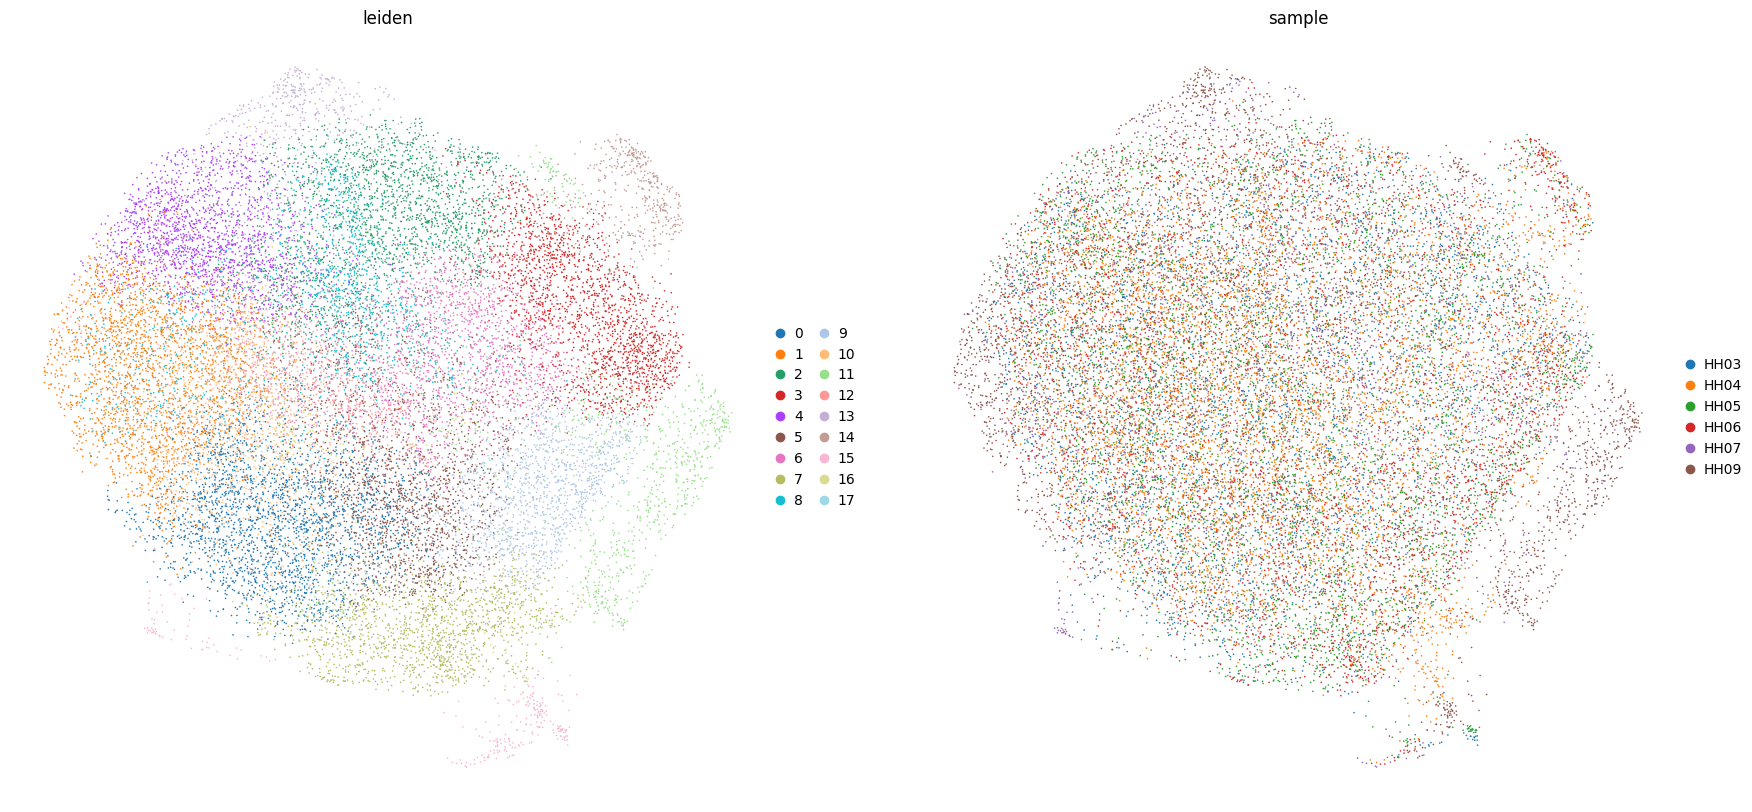

CPU times: user 34min 41s, sys: 14min 41s, total: 49min 22s
Wall time: 4min 1s


In [4]:
%%time

self.cluster(**kws_cluster)
self.plot_umap(["leiden", self._columns["col_sample_id"]])

## Cluster Markers/DEGs

                  scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
leiden names                                                               
0      B2M     46.914482        0.634898    0.0        0.0           1.0   
       HLA-B   42.663696        0.587823    0.0        0.0           1.0   
       TMSB10  42.584846        0.631785    0.0        0.0           1.0   

               pct_nz_reference  n_cells  
leiden names                              
0      B2M             1.000000     2435  
       HLA-B           0.998281     2435  
       TMSB10          0.998478     2435  
                    scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
leiden names                                                                 
1      SH3BGRL3  55.342247        0.995709    0.0        0.0           1.0   
       S100A11   53.067646        0.761086    0.0        0.0           1.0   
       CD52      51.550438        1.314031    0.0        0.0           1.0   

             

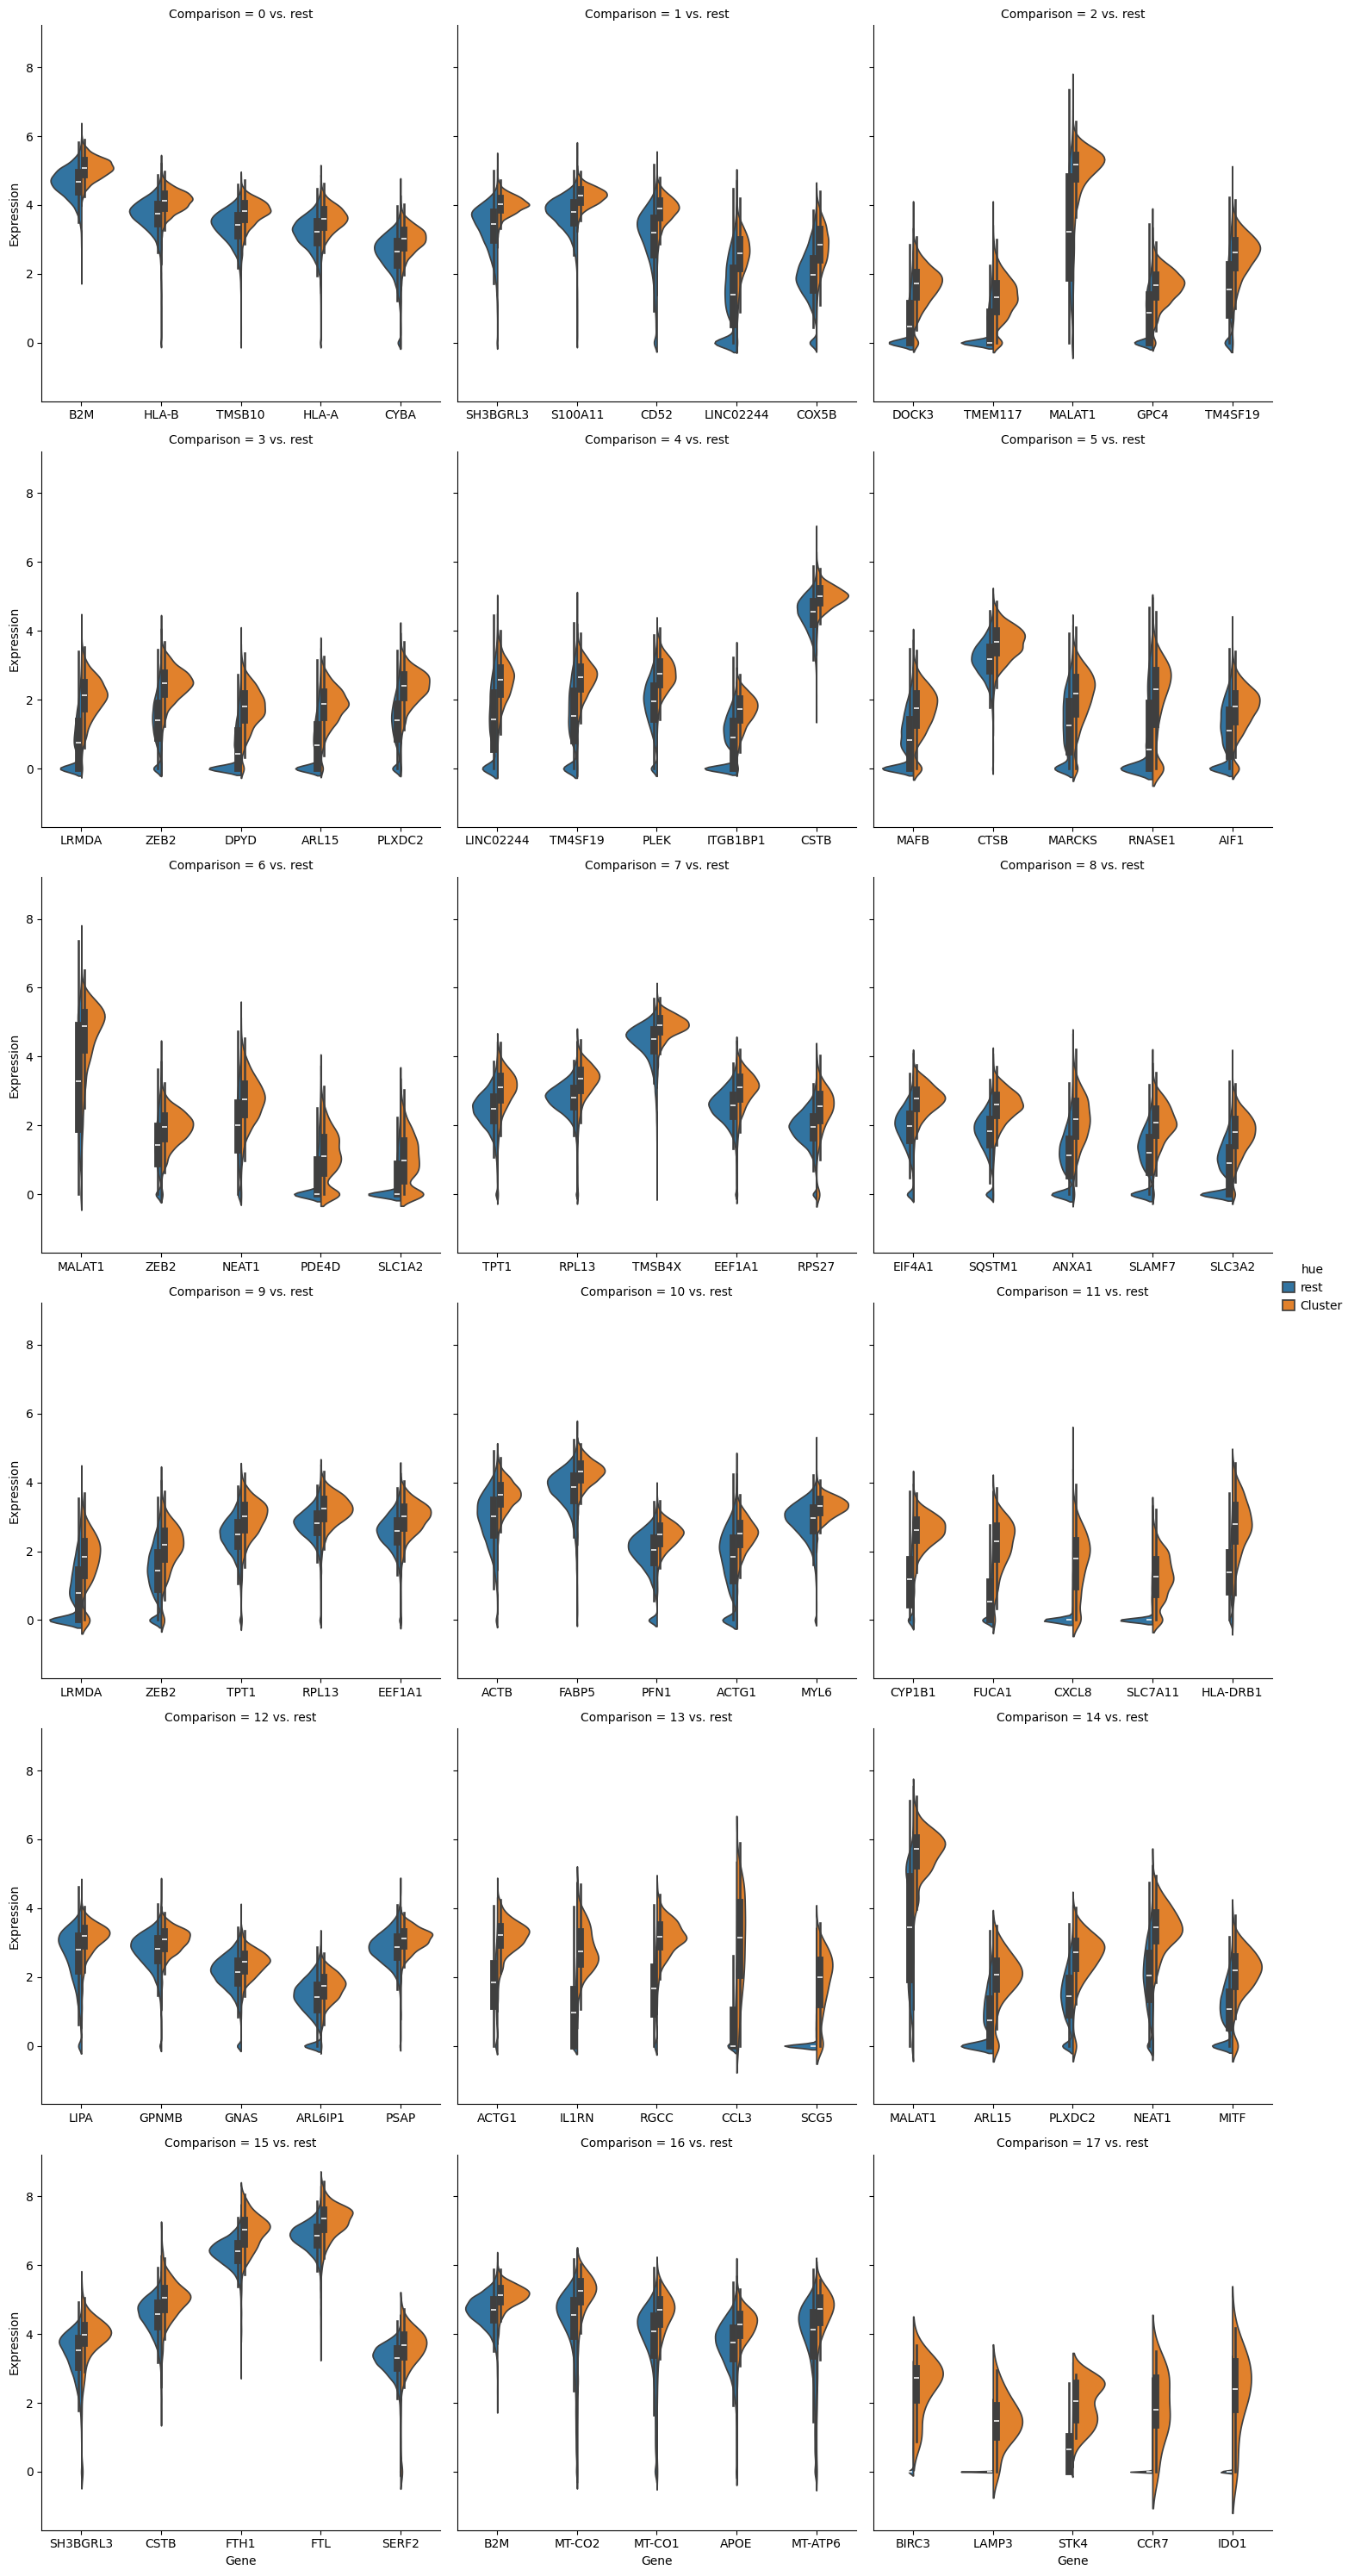

In [5]:
%%time

marks, figs_m = self.find_markers()  # DEGs/cluster markers

## Annotations

### Elmentaite Marker-Based




     LYVE1+ Macrophage  MMP9+ Inflammatory macrophage  Macrophages  Monocytes  \
0                 2.0                            1.0          1.0        0.0   
1                 0.0                            2.0          1.0        0.0   
2                 0.0                            0.0          0.0        1.0   
3                 0.0                            0.0          1.0        0.0   
4                 0.0                            0.0          1.0        0.0   
5                 0.0                            2.0          0.0        1.0   
6                 0.0                            0.0          0.0        0.0   
7                 0.0                            1.0          0.0        0.0   
8                 1.0                            1.0          1.0        0.0   
9                 0.0                            0.0          0.0        1.0   
10                0.0                            0.0          1.0        0.0   
11                1.0               

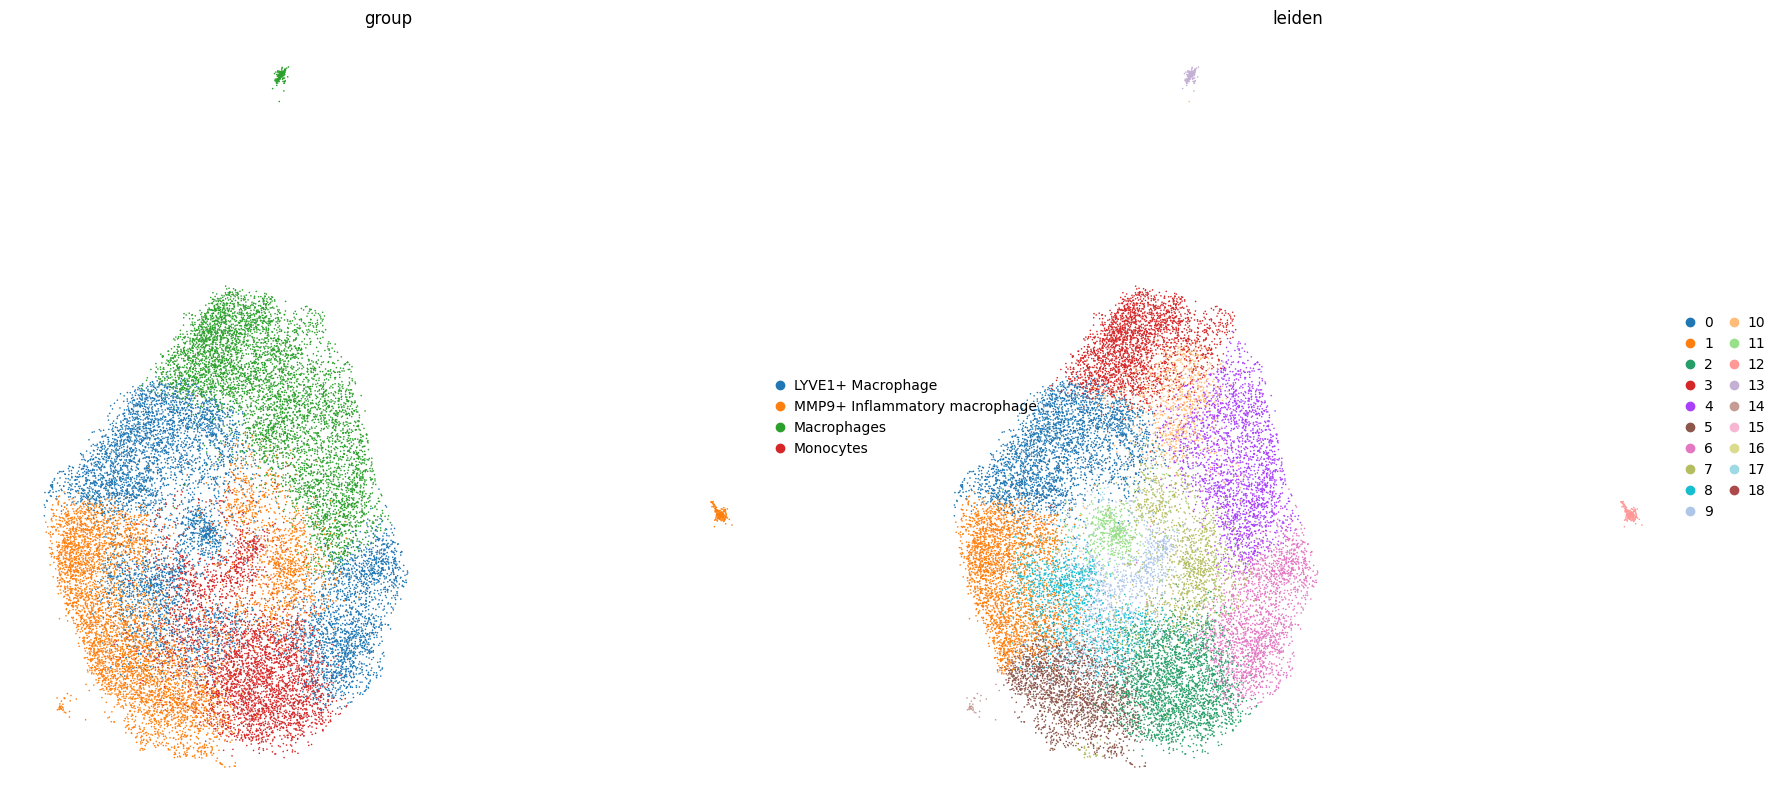

In [7]:
_ = self.annotate_clusters(assign, col_annotation=col_annotation)

### CellTypist

👉 Detailed model information can be found at `https://www.celltypist.org/models`
🔬 Input data has 22799 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


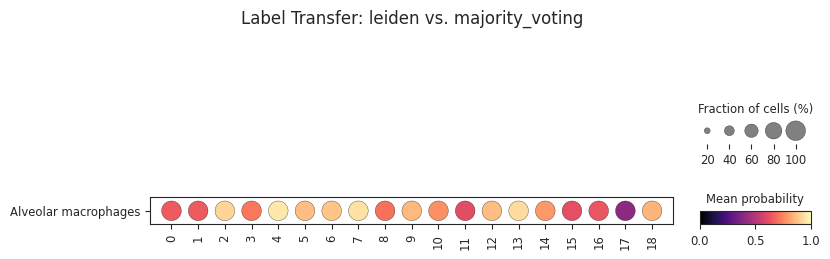

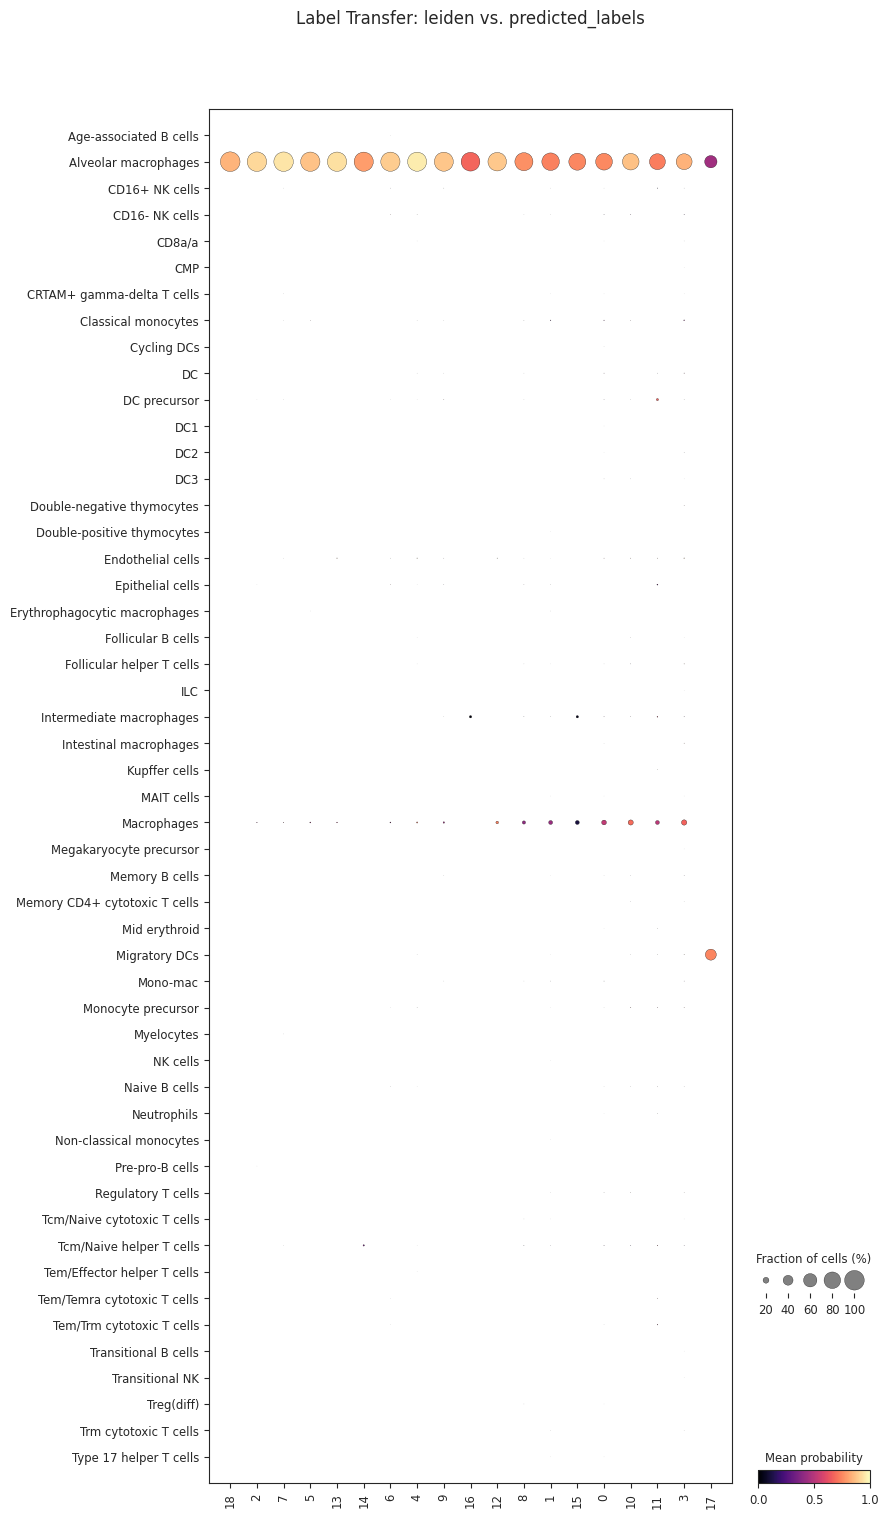

AnnData object with n_obs × n_vars = 22799 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale

[CellTypist prediction result for 22799 query cells
     predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
     decision_matrix: data frame with 22799 query cells and 98 cell types
     probability_matrix: data frame with 22799 query cells and 98 cell types
     adata: AnnData object referred,
 {'label_transfer_majority_voting': None,
  'label_transfer_predicted_labels': None,
  'label_transfer_mv_pl': None,
  'all': <Figure size 2048x480 with 2 Axes>,
  'confidence': <seaborn.axisgrid.FacetGrid at 0x7f6ed9718b20>}]

In [20]:
_, out_celltypist = self.annotate_clusters(model_celltypist)
out_celltypist

## Set Default Cell Type Column

This process allows you not to have to manually specify the `col_cell_type` arguments in downstream methods.

You also could have done this part originally above where you loaded the object with `cr.Spatial()` (e.g., `cr.Spatial(os.path.join(dir_data, file_path), col_cell_type="lump_res1pt5_dist0_npc30", library_id=lib)`).

You can always change it later just like in the cell below if you want to change the default going forward.

If you want to change it just for one method/function call, just specify the `col_cell_type` argument (e.g., if `self._columns["col_cell_type"]` is "lump_res1pt5_dist0_npc30" and you want to plot the Leiden clusters, run `self.plot_spatial(col_cell_type="leiden_res1pt5_dist0_npc30")` instead of just `self.plot_spatial()`).

Currently, it's set to the Leiden clusters. Change it to the CellTypist annotations? (You could also specify any of the other automatic or manual annotation columns if you choose.)

In [10]:
self._columns["col_cell_type"] = col_annotation
# self._columns["col_cell_type"] = "majority_voting"
# self._columns["col_cell_type"] = "predicted_labels"

## Gene Expression Plots


<<< PLOTTING GEX (Heatmap) >>>

<<< PLOTTING GEX (Dot) >>>


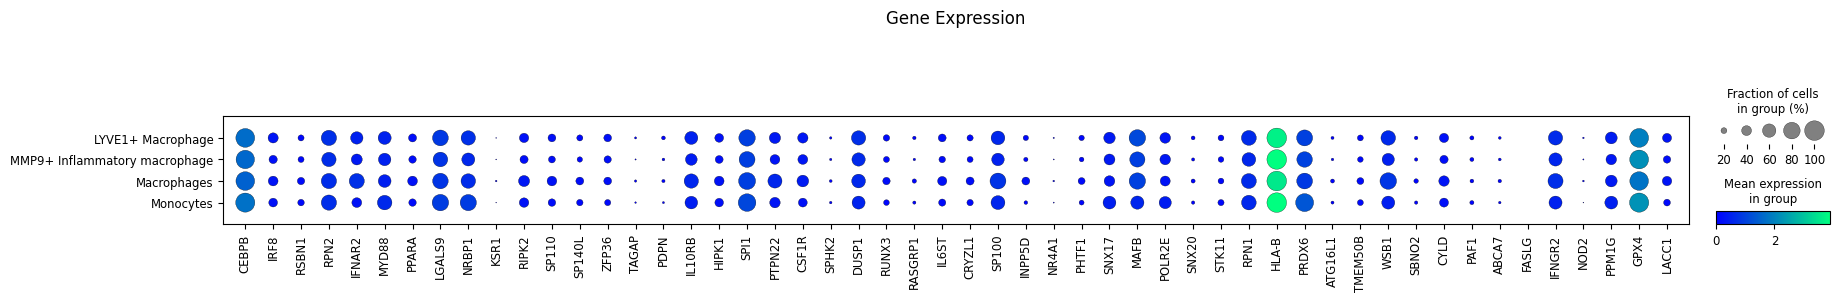

In [46]:
figs = self.plot(self.adata.obs[self._columns["col_target_genes"]].unique(),
                 kind=["heat", "dot"], layer="scaled",
                 kws_heat=dict(vmin=-1.5, vmax=1.5))

## Analyses

Perform downstream CRISPR analyses.

Remember that parameters like `col_cell_type`, `col_condition`, `col_perturbed`, `col_target_genes`, `key_treatment`, and `key_control` are, by default, pulled from `self._columns` and `self._keys`; however, you can override the defaults by passing the appropriate arguments to the methods below (e.g., `self.run_augur(col_cell_type="leiden", ...)`)

### Targeting Efficiency

This example calculates targeting efficiency for each target versus all other perturbations and control. 

**You can specify any list of perturbations to use as a reference group** by passing the argument `key_compare`. Thus, to use just control as a reference group, use the following code:
```python
targ_eff = self.calculate_targeting_efficiency(
    key_compare=[self._keys["key_control"]], plot=False)
```

**To compare both methods, see code in the following dropdown.**

<details>
  <summary>Reference Group Comparison</summary>

  ```python
kde_a = self.calculate_targeting_efficiency(plot=False)
kde_c = self.calculate_targeting_efficiency(
    key_compare=[self._keys["key_control"]], plot=False)  # versus control
kde = pd.concat([kde_a, kde_c], keys=[
    "Versus All Other", "Versus Control"], names=["Reference Group"])
print(kde["Targeting Efficiency"].groupby("Reference Group").describe())
fig = sb.catplot(kde, x=self._columns["col_condition"],
                 y="Targeting Efficiency", hue="Reference Group",
                 height=20, kind="bar")
fig.fig.suptitle("Targeting Efficiency")
fig.set_xticklabels(rotation=90)
  ```

</details>

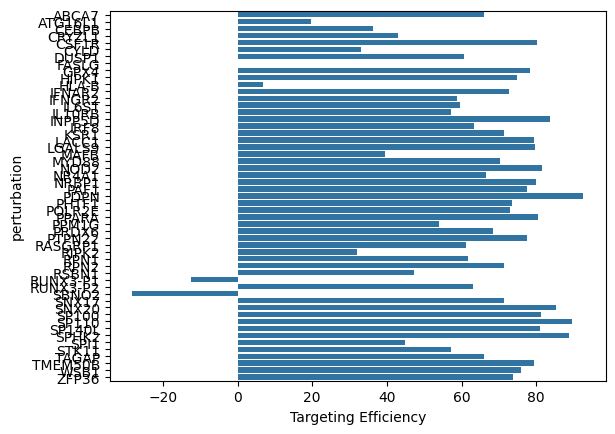

In [11]:
targ_eff = self.calculate_targeting_efficiency()

### Distance Metrics

Compute distance scores comparing gene expression profiles across perturbation conditions. Certain measures can also test whether two profiles came from the same distribution.

This analysis can be helpful in identifying if a perturbation/condition had a significant effect.

See the `pertpy` [tutorials here](https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/distances.html) and [here](https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/distance_tests.html).

The below example is for MMD. See a complete [list of metrics here](https://pertpy.readthedocs.io/en/latest/usage/tools/pertpy.tools.Distance.html#pertpy.tools.Distance).

In [14]:
%%time

_ = self.compute_distance(distance_type="mmd", method="X_pca",
                          col_condition=self._columns["col_condition"],
                          kws_plot=dict(figsize=(15, 15), robust=False))

Output()

Output()

Output()

### Identify Perturbation Escapees (Mixscape)


See the `pertpy` [tutorial here](https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/mixscape.html). It gives useful explanations of the process and how to interpret output.

**Is a perturbed cell detectibly perturbed, and to what extent?** 
* Mixscape first calculates the "**perturbation signature**" by determining which control condition cells most closely resemble each perturbed cell in terms of mRNA expression and then subtracts the control expression from that of the perturbed cells' (i.e., centers perturbed cells' gene expression on their control neighbors).
* Then, it **identifies** and removes perturbed **cells with no detectible perturbation** (i.e., assigns them to predicted classes of perturbed versus not perturbed). 
* You can then create visuals based on whether the cell is detectibly perturbed, "non-perturbed" (not detectibly perturbed), or control (no treatment). 
* Optionally, you can visualize protein expression by this predicted class in certain multi-modal data.

**Are there perturbation-specific clusters?** 
* Mixscape uses linear discriminant analysis (LDA) to cluster cells that resemble each other in terms of gene expression and perturbation condition. 
* _(LDA reduces dimensionality and attempts to maximize the separability of classes. Unperturbed cells are removed from analysis.)_ 

<u> __Features__ </u>  

- Plot targeting efficiency.
- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

If you want to `re-create mixscape plots` **with <u> different target genes and/or proteins of interest**</u> later, you can use `self.plot_mixscape(<ONE OR MORE TARGET GENES>)` without having to re-run Mixscape. If you want a different color for the perturbation score curves, specify `color=` in that method.

```python
_ = self.plot_mixscape(new_list_of_genes, color="red")
```

<u> __Input__ </u> 

See documentation, but the key arguments are listed here.

* **col_cell_type**: If you want to run using a different cell classification column, (e.g., CellTypist annotations that weren't used for the original `self._columns["col_cell_type"]`), you can specify a different column by passing `col_cell_type=<column name>`.
* **target_gene_idents**: A list of gene symbols to focus on in plots/analyses. Specify as True to include all.
* **target_gene_idents**: The default layer of data used is "log1p." Remember that Mixscape centers cells on their control neighbors when considering whether to use centered and/or scaled data.

<u> __Output__ </u>  

Tuple, with the Mixscape `anndata` object as the first element and the figures in the second element as a dictionary.

Assuming you store the figures output in a variable `figs_mix`:
- Targeting Efficiency: `figs_mix["targeting_efficiency"]`
- Differential Expression Ordered by Posterior Probabilities: `figs_mix["DEX_ordered_by_ppp_heat"]`
- Posterior Probabilities Violin Plot: `figs_mix["ppp_violin"]`
- Perturbation Scores: `figs_mix["perturbation_score"]`
- Perturbation Clusters (from LDA): `figs_mix["perturbation_clusters"]`

<u> __Notes__ </u>  

- If `._columns["col_sample_id"]` is not None, perturbation scores will by default be calculated and/or plotted taking that into consideration (e.g., biological replicates) unless `col_split_by=False`. That argument can also be set to a different column name explicitly, in which case that specification will be used as the `col_split_by` argument in Pertpy Mixscape functions in place of sample ID.
- If you want to remove perturbation escapees from future analyses, further steps (i.e., modifying `self.rna` by, for instance, assigning `self.rna = adata_pert`) are required. We don't do so here so as to avoid altering the object.

In [ ]:
%%time

tgis = genes_of_interest[:3]  # just plot some of them for brevity of output
adata_pert, figs_mix = self.run_mixscape(
    target_gene_idents=tgis, col_split_by=False, iter_num=10)

### Cell Type Perturbation Response (Augur)

**Which cell types are most affected by perturbations?** Quantify perturbation responses by cell type with Augur (see `pertpy` [tutorial here](https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/augur.html)), which uses supervised machine learning classification of experimental condition labels (e.g., treated versus untreated). The more separable the condition among cells of a given type, the higher the perturbation effect score.

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type.
- Identify the most important features (genes).

<u> __Input__ </u>  

There are no required arguments. 
* If you want to override defaults drawn from `._columns` and/or `._keys`, specify the appropriate argument (e.g., `col_cell_type`). 
* You can also specify a different `classifer` (default "random_forest_classifer") used in the machine learning classification procedure used to calculate the AUCs/accuracy. 
* You may pass keyword arguments to the Augur predict method by specifying a dictionary in `kws_augur_predict`.
* Specify `select_variance_features` as True to run the original Augur implementation, which removes genes that don't vary much across cell type. If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.
* Specify `n_folds` and/or `subsample_size` to choose the number and sample size of folds in cross-validation.
* Set an integer for `seed` to allow reproducibility across runs.

<u> __Output__ </u>  

Tuple, where the first element is the AnnData object created by the function, the second, the results dictionary, and the third, a dictionary of figures visualizing results. If `copy=False`, results are stored in `self.rna.uns["augurpy_results"]` and scores are stored in `self.rna.obs["augur_score"]`

<u> __Notes__ </u>  

- Sub-sample sizes equal across conditions; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - `select_variance_feature=True`: Uses algorithm close to the original `R Augur` implementation to find and filter by highly variable genes (HVGs).
    - If `False`, it will use the `scanpy`-identified HVGs, so you have to be sure that "highly_variable_features" is a variable in your data from running `self.preprocess()`. This can be complicated if you have a separate layer for perturbation data.

AnnData object with n_obs × n_vars = 22799 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed_original', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', '

Output()

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

cs/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/s

cs/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (3, 1), but need classifier with two classes.

  warnings.warn(
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set 

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

 _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred =

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

❗ Skipping MMP9+ Inflammatory macrophage cell type - the number of samples for at least one class type is less than subsample size 10.


/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (3, 1), but need classifier with two classes.

  warnings.warn(
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metri

_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (4, 1), but need classifier with two classes.

  warnings.warn(
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set 

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (3, 1), but need classifier with two classes.

  warnings.warn(
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set 

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/

site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (3, 1), but need classifier with two classes.

  warnings.warn(
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metri

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

onda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (3, 1), but need classifier with two classes.

  warnings.warn(
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metri

_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (3, 1), but need classifier with two classes.

  warnings.warn(
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set 

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (4, 1), but need classifier with two classes.

  warnings.warn(


/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 50, in _process_predict_proba
    raise ValueError(
ValueError: Got predict_proba of shape (4, 1), but need classifier with two classes.

  warnings.warn(
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metri

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_response_values
    y_pred = _process_predict_proba(
  File "/home/elizabeth/elizabeth/miniconda3/en

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/minic

                  Macrophages  Monocytes  LYVE1+ Macrophage
mean_augur_score          NaN        NaN                NaN
mean_auc                  NaN        NaN                NaN
mean_accuracy             1.0        1.0                1.0
mean_precision            0.0        0.0                0.0
mean_f1                   0.0        0.0                0.0
mean_recall               0.0        0.0                0.0


CPU times: user 3min 21s, sys: 1min 26s, total: 4min 47s
Wall time: 3min 22s


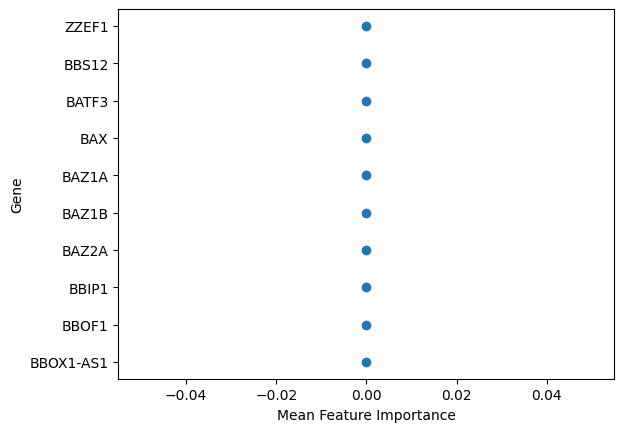

In [ ]:
%%time

adata_augur, res_augur, figs_augur = self.run_augur(
    select_variance_features=True,  # filter by highly variable genes
    classifier="random_forest_classifier", n_folds=3, augur_mode="default",
    kws_umap=kws_cluster["kws_umap"], subsample_size=10,
    kws_augur_predict=dict(span=0.7), n_jobs=20)

### Multi-Cellular Programs

Find multi-cellular programs using Dialogue.

In [5]:
%%time

res_mcp, fig_mcp = self.run_dialogue(
    n_programs=2, cmap="coolwarm",
    col_condition=self._columns["col_target_genes"])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 54 is different from 53)

### Other Perturbation Types

Now let's look at MDP and normoxia conditions (rather than the CRISPRi perturbations, like before).

#### Cell Type Composition

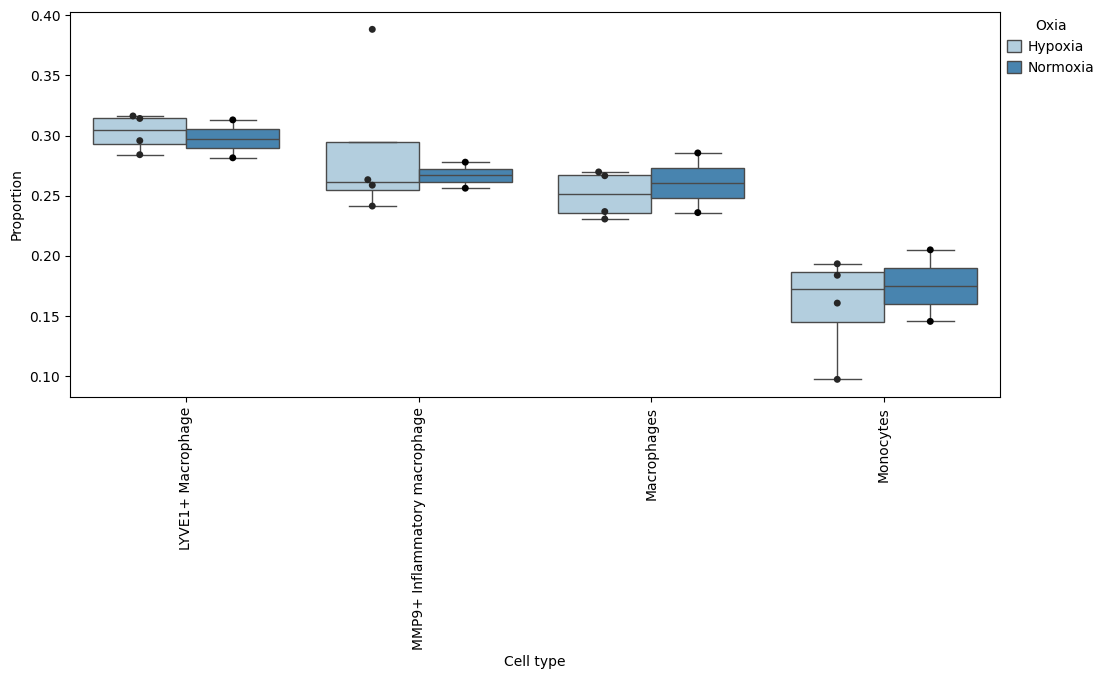

sample: 100%|██████████| 11000/11000 [00:17<00:00, 612.26it/s, 63 steps of size 5.83e-02. acc. prob=0.80] 


                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 6 samples, 4 cell types                                    │
│ Reference cell type                          │ Monocytes                                                        │
│ Formula                                      │ Oxia                                                             │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                Final Parameter  Expected Sample                                                 │
│ Cell Type                                                                                                       │
│ LYVE1+ Macrophage                  3.570           1150.423                                                     │
│ MMP9+ Inflammatory macrophage      3.494           1066.231                                                     │
│ Macrophages                        3.398            968.632                                                     │
│ Monocytes                          2.943            614.547                                                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                               Final Parameter  Expected Sample  log2-fold change                │
│ Covariate      Cell Type                                                                                        │
│ OxiaT.Normoxia LYVE1+ Macrophage                  0.000           1150.423           0.000                      │
│                MMP9+ Inflammatory macrophage      0.000           1066.231           0.000                      │
│                Macrophages                        0.000            968.632           0.000                      │
│                Monocytes                          0.000            614.547           0.000                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 6 samples, 4 cell types                                    │
│ Reference cell type                          │ Monocytes                                                        │
│ Formula                                      │ Oxia                                                             │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                Final Parameter  Expected Sample                                                 │
│ Cell Type                                                                                                       │
│ LYVE1+ Macrophage                  3.570           1150.423                                                     │
│ MMP9+ Inflammatory macrophage      3.494           1066.231                                                     │
│ Macrophages                        3.398            968.632                                                     │
│ Monocytes                          2.943            614.547                                                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                               Final Parameter  Expected Sample  log2-fold change                │
│ Covariate      Cell Type                                                                                        │
│ OxiaT.Normoxia LYVE1+ Macrophage                  0.000           1150.423           0.000                      │
│                MMP9+ Inflammatory macrophage      0.000           1066.231           0.000                      │
│                Macrophages                        0.000            968.632           0.000                      │
│                Monocytes                          0.000            614.547           0.000                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

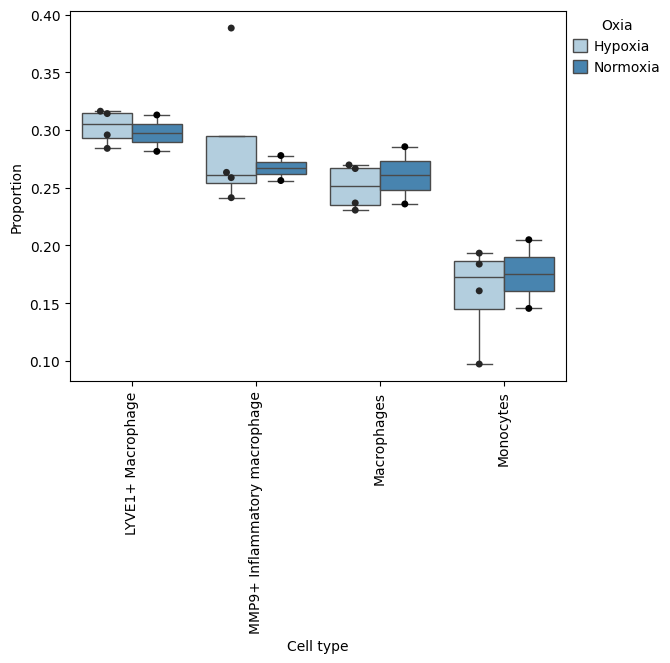

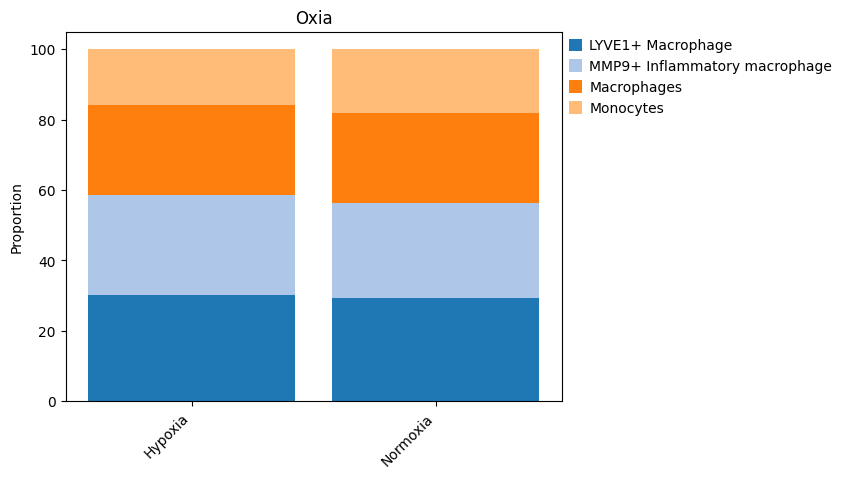




Composition analysis results stored in `self.rna.uns['composition']`.


In [12]:
out_comp = self.run_composition_analysis(
    col_condition="Oxia", covariates=["MDP"],
    key_treatment="Hypoxia", key_control="Normoxia",
    col_cell_type=col_annotation, reference_cell_type="Monocytes",
    col_sample_id=self._columns["col_sample_id"])

#### DEGs

In [13]:
pdata = self.bulk()
model, res = cr.ax.calculate_deg_covariates(
    pdata, layer="counts", col_condition="Oxia", col_covariate="MDP",
    key_control="Normoxia", key_treatment="Hypoxia")

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 8.46 seconds.

Fitting dispersion trend curve...
... done in 1.90 seconds.

Fitting MAP dispersions...
... done in 8.83 seconds.

Fitting LFCs...
... done in 4.14 seconds.

Replacing 36 outlier genes.

Fitting dispersions...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.06 seconds.

Running Wald tests...
... done in 3.97 seconds.



Log2 fold change & Wald test p-value: Oxia Normoxia vs Hypoxia
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbols                                                              
A1BG           657.773499       -0.071309  0.184587 -0.386318  0.699261   
A1BG-AS1        97.832405       -0.072411  0.088602 -0.817258  0.413781   
A1CF             0.168809       -0.943461  1.781801 -0.529498  0.596460   
A2M           3171.207031        0.138956  0.112538  1.234748  0.216924   
A2M-AS1          4.348349       -0.091366  0.399311 -0.228808  0.819018   
...                   ...             ...       ...       ...       ...   
ZXDC           329.414185       -0.049403  0.125773 -0.392796  0.694470   
ZYG11A           0.117159        0.495273  2.421703  0.204515  0.837951   
ZYG11B         599.793030        0.582001  0.177017  3.287833  0.001010   
ZYX           2513.777100        0.041516  0.137329  0.302309  0.762417   
ZZEF1          560.903381       -0.12